# Projet KAGGLE M2 BI : AMP®-Parkinson's Disease Progression Prediction
DESVILLES Roxane

DUFOUR Laura

IANCU Nicoleta

NABI Appoline

On possède un jeu de donnée d'apprentissage contenant pour chaque patient, à chaque visite, son expression normalisée de chaque protéine de notre étude, ses valeurs pour quatres scores ainsi qu'une indication sur sa prise de médicament ou non.

Les quatres scores permettent d'indiquer la gravité, à travers des valeurs plus élevés, de différents types de symptômes de la maladie de Parkinson (Table 1).


**Table 1** : Correspondance des scores de la partie N de l'échelle d'évaluation de la maladie de Parkinson avec les différents types de symptômes.

| Scores   | Symptômes                               |
|----------|-----------------------------------------|
| updrs_1  | Etat mental, comportemental et thymique |
| updrs_2  | Activités dans la vie quotidienne       |
| updrs_3  | Examen moteur                           |
| updrs_4  | Complications du traitement             |

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/MyDrive/Projet_Kaggle/Projet_Kaggle_DESVILLES_DUFOUR_IANCU_NABI/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Projet_Kaggle/Projet_Kaggle_DESVILLES_DUFOUR_IANCU_NABI


In [ ]:
# imports des bibliothèques

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import scikit-learn
import scipy
from pathlib import Path

# Paramètres clé

SEED = 54
THRESH_NA_FEATURE = 0.30
THRESH_NA_PATIENT = 0.50

# chemins des données

DATA_DIR = "./Data"

### Chargement des données

In [ ]:
train_peptides = pd.read_csv(Path(DATA_DIR)/'train_peptides.csv')
train_proteins = pd.read_csv(Path(DATA_DIR)/'train_proteins.csv')
train_clinical_data = pd.read_csv(Path(DATA_DIR)/'train_clinical_data.csv')
supplemental_clinical_data = pd.read_csv(Path(DATA_DIR)/'supplemental_clinical_data.csv')

#Import des Datas :
"""4 fichiers csv sont fournis dans ce projet Kaggle: train_peptides.csv, train_proteins.csv, train_clinical_data.csv et supplemental_clinical_data.csv.
L'objectif est de fusionner les 4 fichiers csv en 2 fichiers csv finaux : train_peptides_labeled.csv et train_proteins_labeled.csv
Ces 2 fichiers finaux contiennent les données peptidiques et protéiques respectivement, ainsi que les scores UPRS +/- et les informations sur la prise de médicaments."""""
import pandas as pd
train_peptides=pd.read_csv('train_peptides.csv')
train_proteins=pd.read_csv('train_proteins.csv')
train_clinical_data=pd.read_csv('train_clinical_data.csv')
supplemental_clinical_data=pd.read_csv('supplemental_clinical_data.csv')
#1. Création d'un seul dataframe avec les données cliniques UPRS par patient_id/visit_id : merge des 2 dataframes contenant les scores UPRS (train_clinical_data + supplemental clinical_data)  :
train_clinical_data_concatenate = pd.concat([train_clinical_data, supplemental_clinical_data], axis=0) #Concaténation des deux df cliniques selon l'axe vertical (axis =0 : on ajoute des lignes)
train_clinical_data_concatenate.sort_values(["patient_id", "visit_month"], ascending=[True, True]) #Tri par patient_id et visit_month
train_clinical_data_concatenate.to_csv('train_clinical_data_concatenate.csv', sep=";", decimal=",", index=False, encoding="utf-8-sig") #Export du df clinique concaténé en csv
print("J'ai des données cliniques initialement pour", train_clinical_data_concatenate["patient_id"].nunique(), "patients, en regroupant les 2 csv avec les scores uprs et +/- medication") #Nombre de patients uniques dans le df clinique concaténé
#2. Suite à la concaténation des 2 df : Vérification  de l'absence de doublon d'index dans les dataframes :
if train_clinical_data_concatenate["visit_id"].duplicated().sum() == 0 :
   print("la concaténation des 2 dataframes cliniques s'est bien passée, il n'y a pas de doublons (visit_id) dans le dataframe concaténé")
else:
    print("Erreur, il y a des doublons (patient_id) dans le dataframe concaténé, Nombre de doublons :")
#3. Merge pour obtenir 2 Dataframes (train_proteins_labeled, train_peptides_labled) = données protéiques/peptidiques + scores UPRS +/- avec ou sans médicament
keys = ["patient_id", "visit_id", "visit_month"] #clés de jointure du merge
train_proteins_labeled = pd.merge(train_proteins, train_clinical_data_concatenate, on=keys)
train_peptides_labeled = pd.merge(train_peptides, train_clinical_data_concatenate, on=keys)
#4.Tri des données du dataframe selon les 3 colonnes : patient_id, visit_month et UniProt (ordre croissant) :
from natsort import natsort_keygen #recours à la librairie natsort pour trier les valeurs de la colonne UniProt de type objet :
natkey = natsort_keygen() #sert à trier les valeurs de type string de la colonne UniProt : sépare les parties numériques et alphabétiques des valeurs de la colonne UniProt
train_proteins_labeled = train_proteins_labeled.sort_values(by=["patient_id", "visit_month", "UniProt"],
    key=lambda col: col.map(natkey) if col.name == "UniProt" else col)
train_peptides_labeled = train_peptides_labeled.sort_values(by=["patient_id", "visit_month", "UniProt"],
    key=lambda col: col.map(natkey) if col.name == "UniProt" else col) #key = applique à chaque valeur de la colonne "UniProt" la fonction natkey via : col.map(natkey)
#5. Vérification des dataframes finaux :
from IPython.display import display
display("Dataframe 1 comportant données protéiques + scores UPRS +/- avec ou sans médicament".upper(),train_proteins_labeled)
#print("types de données contenues dans le dataframe proteins", train_proteins_labeled.dtypes) #Vérification des types de données dans le df protéique labellisé
display("Dataframe 2 comportant données peptidiques + scores UPRS +/- avec ou sans médicament".upper(), train_peptides_labeled)
#print("types de données contenus dans le dataframe peptides:", train_peptides_labeled.dtypes) #Vérification des types de données dans le df peptidique labellisé
train_peptides_labeled.to_csv('train_peptides_labeled.csv', sep=";", decimal=",", index=False, encoding="utf-8-sig") #Export du df peptidique labellisé en csv
train_proteins_labeled.to_csv('train_proteins_labeled.csv', sep=";", decimal=",", index=False, encoding="utf-8-sig") #Export du df protéique labellisé en csv

##PIVOT DU DATAFRAME POUR OBTENIR LES COLONNES DES DIFFERENTES PROTEINES :
#Pivot du dataframe train_proteins_labeled pour avoir en colonnes les différentes protéines dosées :
train_proteins_pivot = train_proteins_labeled.pivot_table(index=["patient_id", "visit_month"],
                                            columns="UniProt", values="NPX").reset_index()
train_proteins_pivot_labeled = pd.merge(train_proteins_pivot, train_clinical_data_concatenate, on=["patient_id", "visit_month"])
#Suppression de la colonne visit_id qui n'est plus utile pour la vectorisation (patient_id/visit_month suffisent pour identifier une visite) :
train_proteins_pivot_labeled.drop(columns=["visit_id"], inplace=True)
display("DATAFRAME PROTEINES ET UPRS_SCORE : C'EST SUR CES DONNEES QUE NOUS ALLONS TRAVAILLER POUR CE PROJET KAGGLE", train_proteins_pivot_labeled)
#Export du dataframe pivoté en csv :
train_proteins_pivot_labeled.to_csv('train_proteins_pivot_labeled.csv', sep=";", decimal=",", index=False, encoding="utf-8-sig")


[clin] shape=(2615, 8)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN


[prot] shape=(232741, 5)


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8


Top 10 features les plus manquantes:\n Q99829    0.821415
Q99832    0.775908
Q562R1    0.773614
P01780    0.759847
Q6UX71    0.758317
O75326    0.747228
P06310    0.746080
P19827    0.743021
P36980    0.743021
P05408    0.739579
dtype: float64
Visites avec >=3 UPDRS manquants: 0


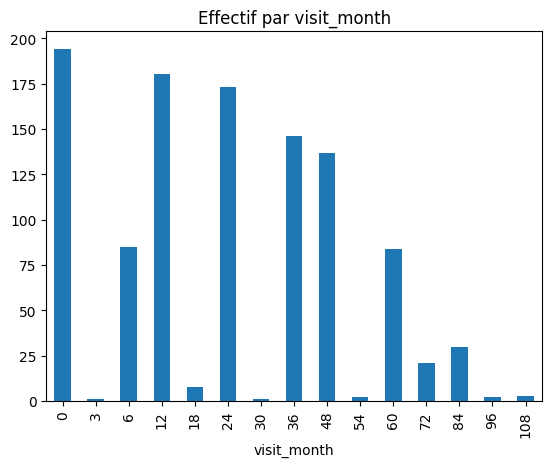

,updrs_1,updrs_2,updrs_3,updrs_4
count,1067.000000,1067.000000,1057.000000,568.000000
mean,6.568885,5.825679,17.306528,1.911972
std,5.332622,5.932356,15.022227,3.079086
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,0.000000
50%,5.000000,4.000000,16.000000,0.000000
75%,9.000000,9.000000,28.000000,3.000000
max,33.000000,29.000000,78.000000,20.000000


,updrs_1,updrs_2,updrs_3,updrs_4
visit_month,,,,
0,5.32,4.10,13.03,1.79
3,6.00,5.00,25.00,NaN
6,6.51,8.14,24.00,0.00
12,6.43,5.54,16.47,1.46
18,4.88,4.50,7.86,0.14
24,6.69,5.79,16.65,1.90
30,14.00,15.00,29.00,2.00
36,7.44,6.12,17.95,1.88
48,6.89,6.34,18.40,2.06


In [ ]:
DATA_DIR = Path(DATA_DIR)

# 1) Chargement
clin = pd.read_csv(DATA_DIR/"train_clinical_data.csv")
prot = pd.read_csv(DATA_DIR/"train_proteins.csv")
# peptides/supplemental si utile:
# pept = pd.read_csv(DATA_DIR/"train_peptides.csv")
# clin_sup = pd.read_csv(DATA_DIR/"supplemental_clinical_data.csv")

# 2) Contrôles clés
for df_, name in [(clin,"clin"), (prot,"prot")]:
    print(f"[{name}] shape={df_.shape}")
    assert {"patient_id","visit_month"}.issubset(df_.columns), f"Colonnes manquantes dans {name}"
    # Optionnel: afficher quelques têtes
    display(df_.head(3))

# 3) Pivot protéines
prot_pivot = prot.pivot_table(index=["patient_id","visit_month"],
                              columns="UniProt", values="NPX", aggfunc="mean").reset_index()

# 4) Fusion pivot + clinique
df = pd.merge(clin, prot_pivot, on=["patient_id","visit_month"], how="left")

# 5) Cartographie NA brute
targets = ["updrs_1","updrs_2","updrs_3","updrs_4"]
feat_cols = [c for c in df.columns if c not in ["patient_id","visit_month"] + targets]
na_feat = df[feat_cols].isna().mean().sort_values(ascending=False)
na_row  = df[feat_cols].isna().mean(axis=1)

print("Top 10 features les plus manquantes:\\n", na_feat.head(10))

# 6) Filtrages
keep_feat = na_feat[na_feat <= THRESH_NA_FEATURE].index
row_mask = df[feat_cols].isna().mean(axis=1) <= THRESH_NA_PATIENT
df = df.loc[row_mask, ["patient_id","visit_month"] + list(keep_feat) + targets].copy()

# 7) Détection visites quasi vides en cibles
bad_visits = df[["patient_id","visit_month"] + targets].copy()
bad_visits["n_updrs_na"] = bad_visits[targets].isna().sum(axis=1)
bad_visits = bad_visits[bad_visits["n_updrs_na"] >= 3]
print(f"Visites avec >=3 UPDRS manquants: {len(bad_visits)}")

# 8) Stats UPDRS
display(df[targets].describe())
display(df.groupby("visit_month")[targets].mean().round(2))


- Chargement → cartographie NA → filtrage (seuils) → imputation intra-patient→KNN → pipeline (scaling+PCA, GroupKFold) → EDA uni/multi → temporalité → exports.

- Interpolation par la médiane => graphe pour montrer que l'interpolation linéaire n'est pas intéressante ?


### Protéines

**Cohorte de patients dans chaque dataframe (248 patients dans chaque dataframe)**

In [ ]:
n_patients_peptides = train_peptides["patient_id"].nunique()
print("- Nombre de patients avec données peptidiques :", n_patients_peptides)
n_patients_proteins = train_proteins["patient_id"].nunique()
print("- Nombre de patients avec des données protéiques :", n_patients_proteins)

- Nombre de patients avec données peptidiques : 247
- Nombre de patients avec des données protéiques : 248


**Liste des patients avec données protéiques et/ou peptidiques :**

In [ ]:
pept_patients = set(train_peptides["patient_id"].unique())
prot_patients = set(train_proteins["patient_id"].unique())
diff = pept_patients - prot_patients
if len(diff) == 0:
    print("(les patients ont à la fois des données peptidiques et des données protéiques)")
else:
    print("- Liste des patients avec données peptidiques sans données protéiques:", diff)

(les patients ont à la fois des données peptidiques et des données protéiques)


**Nombre de visites par patient dans chaque dataframe :**

In [ ]:
print("- Moyenne de visites par patient", train_proteins.groupby("patient_id")["visit_month"].nunique().mean().round(2))

- Moyenne de visites par patient 4.49


**Min et max mois de visites d'un patient**

In [ ]:
print("- Valeur min des mois visites d'un patient :", train_proteins["visit_month"].min())
print("- Valeur max des mois de visite d'un patient :", train_proteins["visit_month"].max())

- Valeur min des mois visites d'un patient : 0
- Valeur max des mois de visite d'un patient : 108


**Statistiques descriptives des données protéiques dosées (NPX) :**


In [ ]:
n_proteins = train_proteins["UniProt"].unique().tolist()
print("- Nombre des différentes protéines dosées (dans le LCR) :", len(n_proteins))
nb_patient = train_proteins["patient_id"].nunique() #Nombre de patients uniques

- Nombre des différentes protéines dosées (dans le LCR) : 227


**Répartition des visites par patient dans le dataframe pivoté :**


- Nombre de patients uniques dans le dataframe pivoté : 248


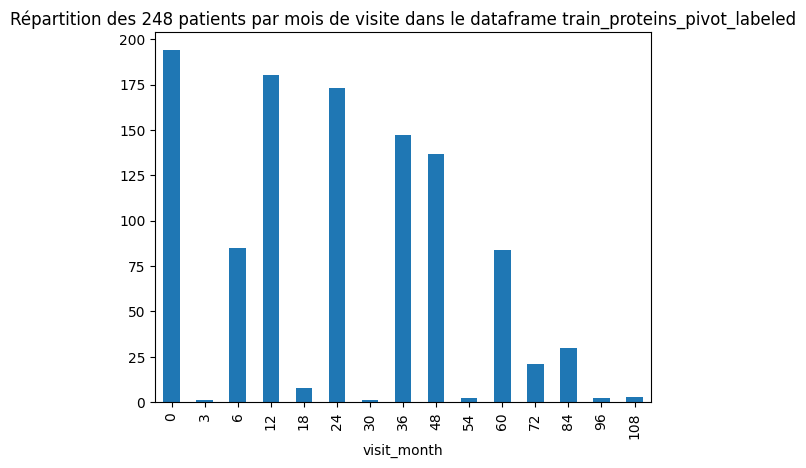

In [ ]:
train_proteins_pivot_labeled["visit_month"].value_counts().sort_index().plot(
    kind="bar",
    title=(f"Répartition des {n_patients_proteins} patients par mois de visite dans le dataframe train_proteins_pivot_labeled"))
print("- Nombre de patients uniques dans le dataframe pivoté :", nb_patient)

In [ ]:
# Sélectionner uniquement les colonnes protéines (tout sauf patient_id et visit_month)
protein_cols = train_proteins_pivot_labeled.columns.difference(["patient_id", "visit_month", "updrs_1", "updrs_2", "updrs_3", "updrs_4", "upd23b_clinical_state_on_medication"])
# Colonnes contextuelles (non imputées)
context_cols = ["patient_id", "visit_month", "updrs_1", "updrs_2", "updrs_3", "updrs_4", "upd23b_clinical_state_on_medication"]
# Colonnes de protéines
protein_cols = train_proteins_pivot_labeled.columns.difference(context_cols)

In [ ]:
# Calcul du nombre de valeurs manquantes par protéine :
missing_values_proteins = train_proteins_pivot_labeled[protein_cols].isna().any().sum() #nb de colonnes protéines avec au moins une valeur manquante
print("- Nombre de protéines avec valeurs manquantes(NaN) dans le df train_proteins_pivot_labeled pour au moins une visite :\n", missing_values_proteins)
missing_counts = (train_proteins_pivot_labeled[protein_cols].isna().sum().reset_index().rename(columns={"index": "Protéine", 0: "Valeurs_manquantes"}).sort_values("Valeurs_manquantes", ascending=False).reset_index(drop=True))
# Génération d'un csv regroupant valeurs manquantes par protéine : missing_values_by_protein.csv
missing_counts.to_csv("missing_values_by_protein.csv", sep=";", index=False, encoding="utf-8-sig")

- Nombre de protéines avec valeurs manquantes(NaN) dans le df train_proteins_pivot_labeled pour au moins une visite :
 200


## EDA : analyse univariée :

/tmp/ipython-input-682977330.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_tmp,
/tmp/ipython-input-682977330.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_tmp,
/tmp/ipython-input-682977330.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_tmp,
/tmp/ipython-input-682977330.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_tmp,


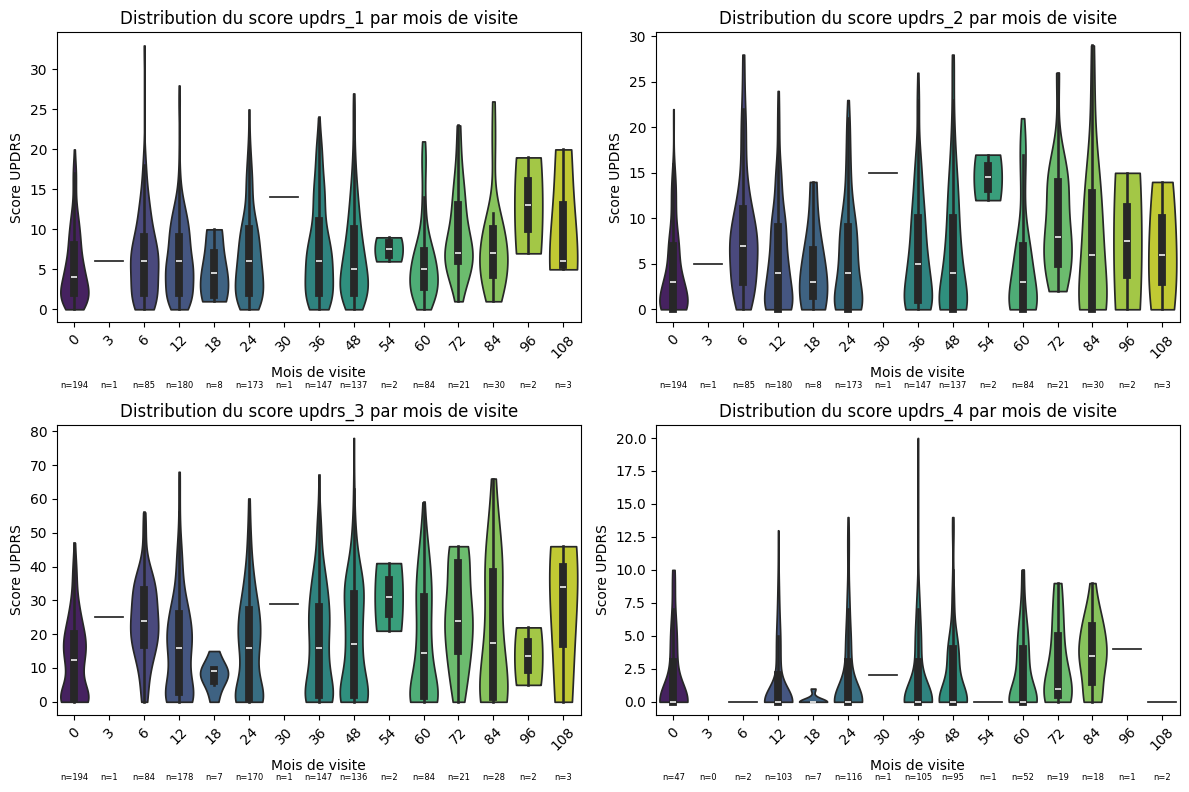

/tmp/ipython-input-682977330.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipython-input-682977330.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipython-input-682977330.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipython-input-682977330.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


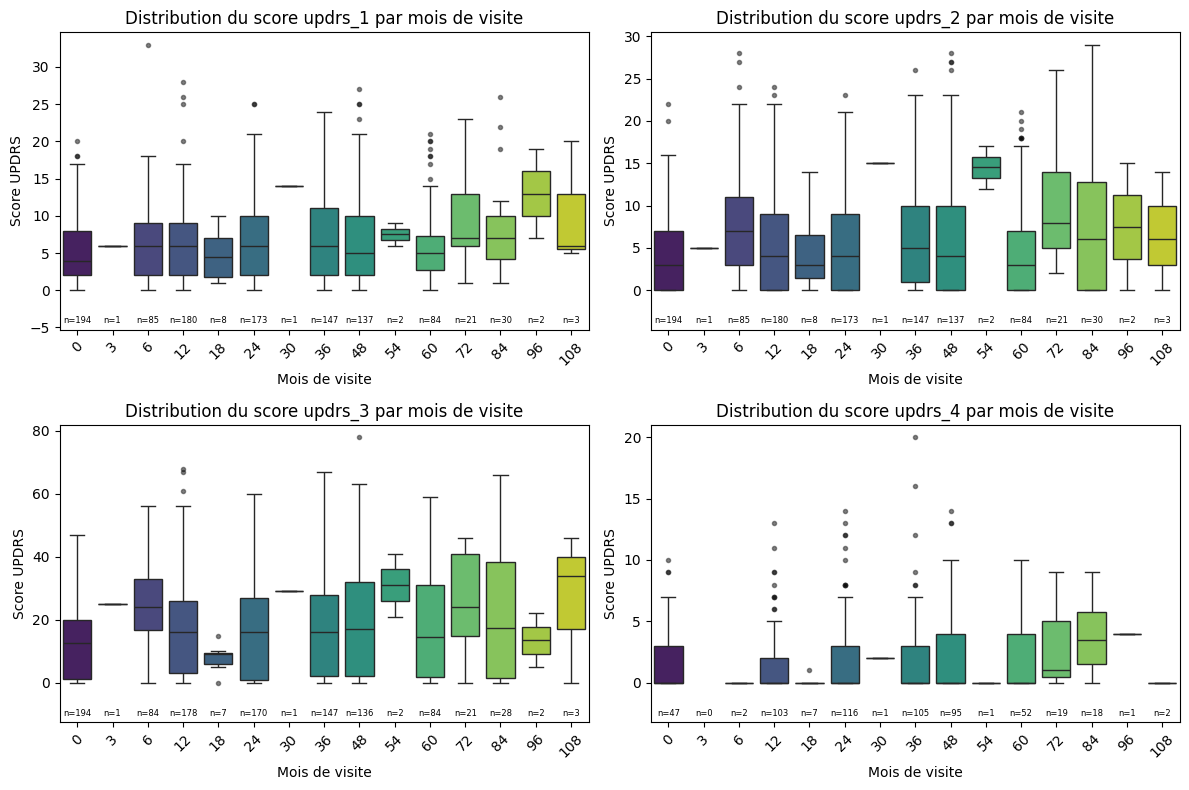

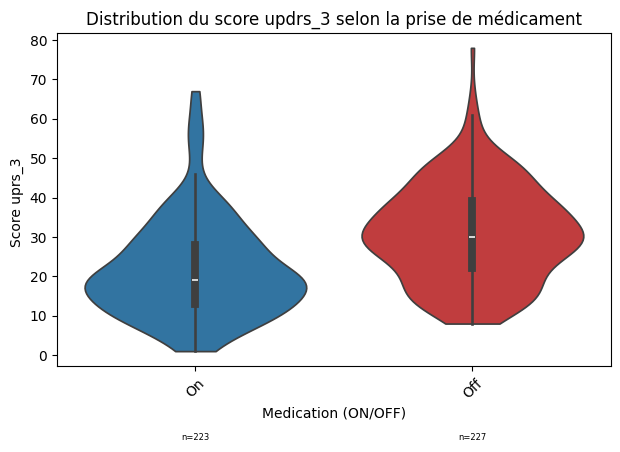

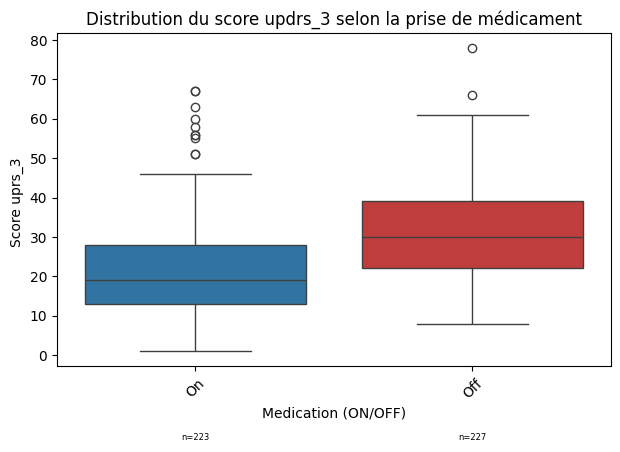

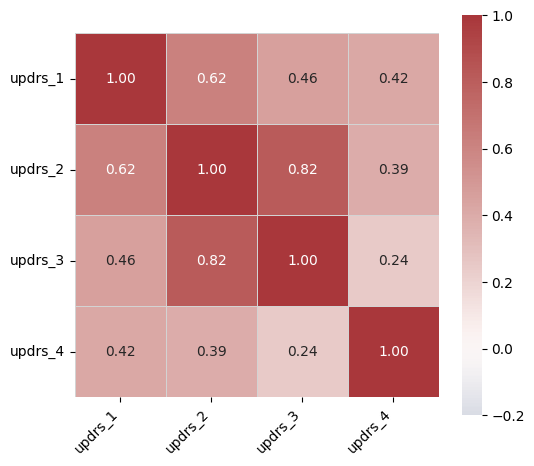

In [ ]:
#VIOLIN PLOTS : DISTRIBUTION DES VALEURS DE SCORES PAR PROTEINE PAR MOIS DE VISITE :
#On prépare un tableau long :
import seaborn as sns
import matplotlib.pyplot as plt

scores = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

plt.figure(figsize=(12, 8))
for i, score in enumerate(scores, 1):
    plt.subplot(2, 2, i)

    # On retire uniquement les NaN de la colonne courante (pas les autres)
    df_tmp = train_proteins_pivot_labeled[["visit_month", score]].dropna(subset=[score])

    # On force l’ordre des mois si besoin
        # Ordre des mois
    df_tmp["visit_month"] = pd.Categorical(df_tmp["visit_month"],ordered=True,categories=sorted(train_proteins_pivot_labeled["visit_month"].unique()))

    sns.violinplot(data=df_tmp,
        x="visit_month",
        y=score,
        palette="viridis",
        cut=0)  # cut=0 pour limiter la forme du violon aux données)

    plt.title(f"Distribution du score {score} par mois de visite")
    plt.xlabel("Mois de visite")
    plt.ylabel("Score UPDRS")
    plt.xticks(rotation=45)
    # --- Effectifs par mois ---
    counts = df_tmp.groupby("visit_month", observed=False)[score].count()
    ymin, ymax = plt.ylim()
    for x, month in enumerate(counts.index):
        n = counts.loc[month]
        plt.text(
            x,
            ymin - (ymax - ymin) * 0.2,
            f"n={n}",
            ha='center', va='top',
            fontsize=6, color="black"
        )

plt.tight_layout()
plt.savefig(fname="violinplots_many.png")
plt.show()

#BOX PLOTS : DISTRIBUTION DES VALEURS DE SCORES PAR PROTEINE PAR MOIS DE VISITE :
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
scores = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

plt.figure(figsize=(12, 8))
for i, score in enumerate(scores, 1):
    plt.subplot(2, 2, i)
    # On retire uniquement les NaN du score courant
    df_tmp = train_proteins_pivot_labeled[["visit_month", score]].dropna(subset=[score])
    # Ordre des mois
    df_tmp["visit_month"] = pd.Categorical(df_tmp["visit_month"],ordered=True,categories=sorted(train_proteins_pivot_labeled["visit_month"].unique()))
    # --- Définition du style des outliers ---
    flier_props = dict(marker='o', markersize=3, markerfacecolor='black', alpha=0.5)
    # --- Boxplot ---
    ax = sns.boxplot(
        data=df_tmp,
        x="visit_month",
        y=score,
        palette="viridis",
        flierprops=flier_props,  # petits points noirs pour les outliers
        linewidth=1
    )
    plt.title(f"Distribution du score {score} par mois de visite", fontsize=12)
    plt.xlabel("Mois de visite")
    plt.ylabel("Score UPDRS")
    plt.xticks(rotation=45)

    # --- Effectifs par mois ---
    counts = df_tmp.groupby("visit_month", observed=False)[score].count()
    ymin, ymax = ax.get_ylim()
    for x, month in enumerate(counts.index):
        n = counts.loc[month]
        ax.text(
            x,
            ymin - (ymax - ymin) * 0.05,
            f"n={n}",
            ha='center', va='top',
            fontsize=6, color="black"
        )
    # Ajustement de l’espace en bas
    ax.set_ylim(ymin - (ymax - ymin) * 0.1, ymax)

plt.tight_layout()
plt.show()

#===================================================
#VIOLIN PLOTS : ON ET OFF MEDICATION SUR SCORE UPRS3
scores = ["updrs_3"]

plt.figure(figsize=(12, 8))
for i, score in enumerate(scores, 1):
    plt.subplot(2, 2, i)
    # On retire uniquement les NaN les colonnes ou au moins une des 2 colonnes (medication et uprs3 est manbuante) a une valeur NaN
    df_tmp = train_proteins_pivot_labeled[["upd23b_clinical_state_on_medication", score]].dropna()

    sns.violinplot(data=df_tmp,
        x="upd23b_clinical_state_on_medication",
        y=score,
        hue= "upd23b_clinical_state_on_medication",
        palette=["#1f77b4", "#d62728"],
        cut=0)  # cut=0 pour limiter la forme du violon aux données)

    plt.title(f"Distribution du score {score} selon la prise de médicament")
    plt.xlabel("Medication (ON/OFF)")
    plt.ylabel("Score uprs_3 ")
    plt.xticks(rotation=45)
    # --- Effectifs par medication ON/OFF ---
    counts = df_tmp.groupby("upd23b_clinical_state_on_medication", observed=False)[score].count()
    ymin, ymax = plt.ylim()
    for x, month in enumerate(counts.index):
        n = counts.loc[month]
        plt.text(
            x,
            ymin - (ymax - ymin) * 0.2,
            f"n={n}",
            ha='center', va='top',
            fontsize=6, color="black"
        )

plt.tight_layout()
plt.savefig(fname="violinplots.png")
plt.show()

#BOX PLOT : ON ET OFF MEDICATION SUR SCORE UPRS3 : VERIFIER CAR ERREUR DANS LES EFFECTIFS
scores = ["updrs_3"]

plt.figure(figsize=(12, 8))
for i, score in enumerate(scores, 1):
    plt.subplot(2, 2, i)
    # On retire uniquement les NaN les colonnes ou au moins une des 2 colonnes (medication et uprs3 est manbuante) a une valeur NaN
    df_tmp = train_proteins_pivot_labeled[["upd23b_clinical_state_on_medication", score]].dropna()

    sns.boxplot(data=df_tmp,
        x="upd23b_clinical_state_on_medication",
        y=score,
        hue= "upd23b_clinical_state_on_medication",
        palette=["#1f77b4", "#d62728"])

    plt.title(f"Distribution du score {score} selon la prise de médicament")
    plt.xlabel("Medication (ON/OFF)")
    plt.ylabel("Score uprs_3 ")
    plt.xticks(rotation=45)
    # --- Effectifs par medication ON/OFF ---
    counts = df_tmp.groupby("upd23b_clinical_state_on_medication", observed=False)[score].count()
    ymin, ymax = plt.ylim()
    for x, month in enumerate(counts.index):
        n = counts.loc[month]
        plt.text(
            x,
            ymin - (ymax - ymin) * 0.2,
            f"n={n}",
            ha='center', va='top',
            fontsize=6, color="black"
        )

plt.tight_layout()
plt.show()

#===================================================
# 1) MATRICE DE CORRÉLATION  DES SCORES UPRS "TOUS MOIS CONFONDUS" : L'objectif était d'obtenir une vision glocale
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

scores = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]

# Corrélation globale (Spearman, pairwise)
corr_global = train_proteins_pivot_labeled[scores].corr(method="spearman", min_periods=5)

plt.figure(figsize=(5.5, 4.8))
ax = sns.heatmap(
    corr_global, vmin=-0.20, vmax=1, annot=True, fmt=".2f",
    square=True, center=0, cbar=True,
    cmap="vlag", linewidths=0.5, linecolor="lightgray")

#ax.set_title("Matrice de Corrélations des scores UPDRS - Spearman", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("heatmap")
plt.show()


Ajout du masque vector

In [ ]:
## AJOUT DU MASK VECTEURS BINAIRE (0,1) (SOIT 4 COLONNES) POUR INDIQUER SI LES 4 SCORES UPRS SONT PRESENTES OU NON (1 = PRESENT, 0 = ABSENT) POUR CHAQUE LIGNE DU DATAFRAME train_proteins_pivot_labeled  /
#On crée un dataframe mask avec 4 colonnes avec le score binaire du vecteur : 0 (absent) ou 1 (présent) pour chaque score UPRS
cols = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
df_uprs_mask = (train_proteins_pivot_labeled[cols].notna().astype(int).add_suffix("_mask")) #Création du df mask avec 4 colonnes (1 par score UPRS) avec 1 si le score est présent et 0 s'il est absent
#On concatène le df mask au df train_proteins_pivot_labeled
train_proteins_pivot_labeled_mask_uprs_vectors = pd.concat([train_proteins_pivot_labeled, df_uprs_mask], axis=1)
#on génère le pdf final avec le mask en csv :
train_proteins_pivot_labeled_mask_uprs_vectors.to_csv('train_proteins_pivot_labeled_with_mask.csv', sep=";", decimal=",", index=False, encoding="utf-8-sig") #Export du df pivoté avec mask en csv
print("- Dataframe final avec les mask vectors ajoutés aux scores UPRS : train_proteins_pivot_labeled_with_mask.csv")
train_proteins_pivot_labeled_mask_uprs_vectors.head()

- Dataframe final avec les mask vectors ajoutés aux scores UPRS : train_proteins_pivot_labeled_with_mask.csv


,patient_id,visit_month,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,...,Q9Y6R7,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_1_mask,updrs_2_mask,updrs_3_mask,updrs_4_mask
0,55,0,11254.3,732430.0,39585.8,41526.9,31238.00,4202.71,177775.0,62898.2,...,18953.5,10.0,6.0,15.0,NaN,NaN,1,1,1,0
1,55,6,13163.6,630465.0,35220.8,41295.0,26219.90,4416.42,165638.0,62567.5,...,16642.7,8.0,10.0,34.0,NaN,NaN,1,1,1,0
2,55,12,15257.6,815083.0,41650.9,39763.3,30703.60,4343.60,151073.0,66963.1,...,19290.9,10.0,10.0,41.0,0.0,On,1,1,1,1
3,55,36,13530.8,753832.0,43048.9,43503.6,33577.60,5367.06,101056.0,67588.6,...,21717.1,17.0,18.0,51.0,0.0,On,1,1,1,1
4,942,6,11218.7,399518.0,20581.0,31290.9,6173.58,2564.37,160526.0,43423.1,...,15251.2,8.0,2.0,21.0,NaN,NaN,1,1,1,0


## EDA : Visualisation des données protéiques

Une matrice de corrélation protéine×protéine (calculée sur leurs profils temporels) révèlent les protéines qui co-évoluent au fil des visites — ceci révèle des modules et des possibles familles fonctionnelles (clustering) .

In [ ]:
protein_cols = train_proteins_pivot_labeled.columns.difference(["patient_id", "visit_month", "updrs_1", "updrs_2", "updrs_3", "updrs_4", "upd23b_clinical_state_on_medication"])


/tmp/ipython-input-946406055.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("visit_month")[protein_cols]


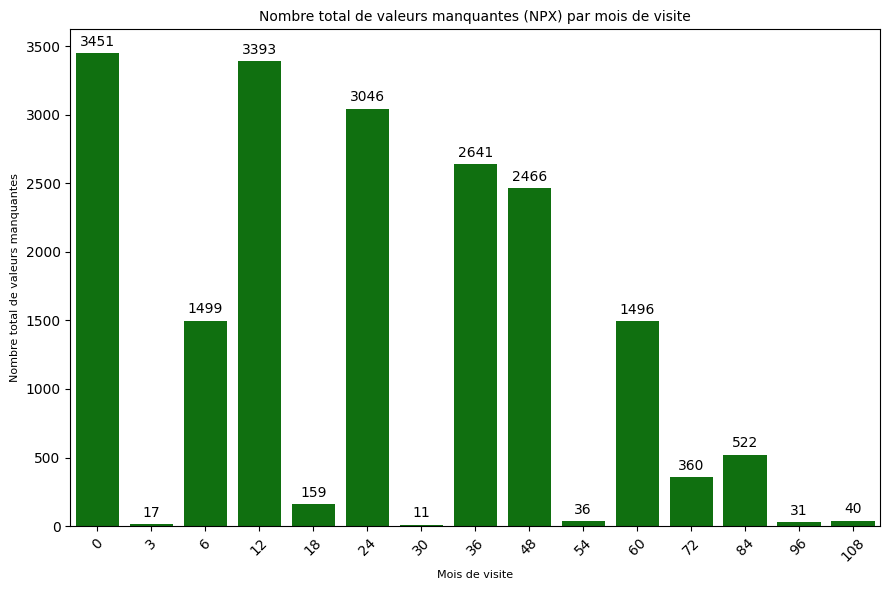

Protéines avec NaN (top 5) et nombre de NaN :
Q99829    601
Q99832    482
Q562R1    476
P01780    440
Q6UX71    436
dtype: int64 

Protéines utilisées pour QQ-plot (5) : ['Q99829', 'Q99832', 'Q562R1', 'P01780', 'Q6UX71']


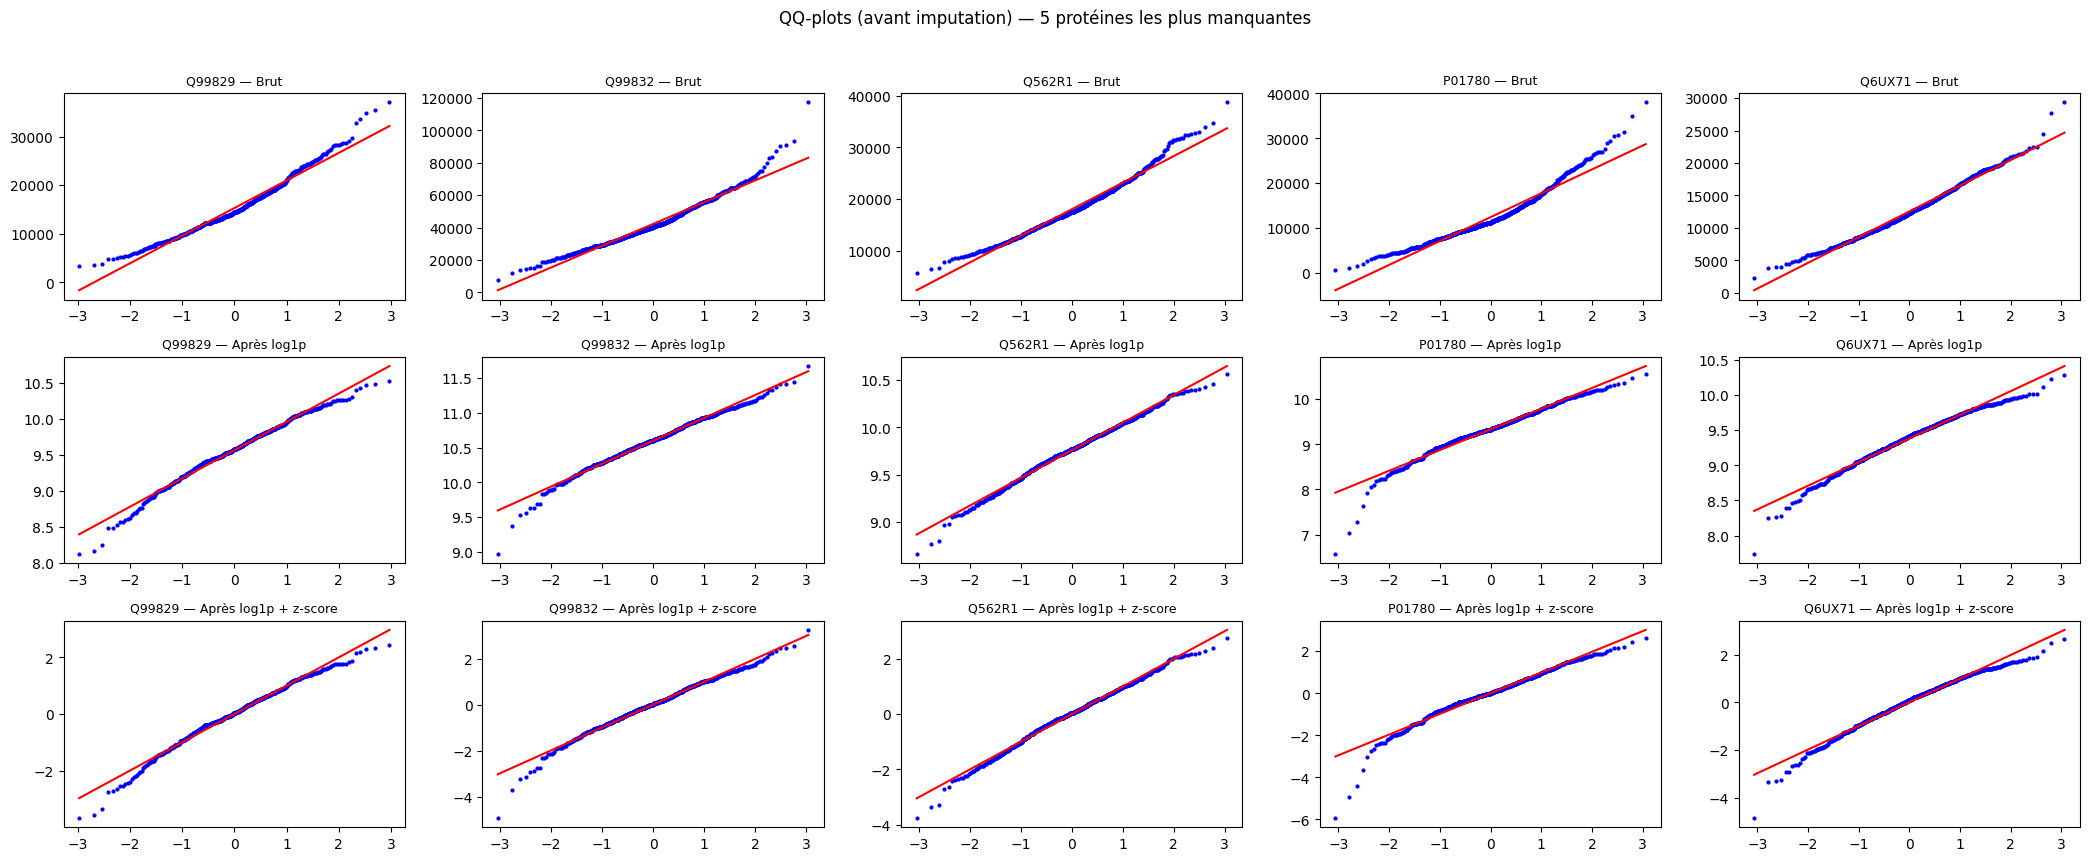

'Données brutes (protéines × visites):'

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,11254.3,732430.0,39585.8,41526.9,31238.00,4202.71,177775.0,62898.2,333376.0,166850.0,...,365475.0,35528.0,97005.6,23122.50,60912.6,408698.0,NaN,29758.8,23833.70,18953.50
1,11648.9,419015.0,35053.8,NaN,17466.30,2784.40,118752.0,40274.9,166322.0,93873.7,...,306280.0,24931.3,NaN,12610.90,40018.9,164826.0,55379.8,31563.0,19771.60,14699.50
2,21361.8,866985.0,32035.1,NaN,13373.10,NaN,269106.0,81580.2,315740.0,297865.0,...,63839.7,58941.2,116485.0,14041.30,66752.8,499634.0,64302.3,25588.8,26346.20,23597.10
3,NaN,579829.0,28259.8,29883.2,19134.10,1884.61,134409.0,70664.8,213295.0,229999.0,...,224909.0,32224.2,127529.0,14148.60,26387.0,294153.0,55047.2,17880.5,25630.00,17990.90
4,10887.0,267402.0,11390.4,15696.3,6646.16,2962.85,61555.3,25927.8,72635.7,110550.0,...,232382.0,NaN,72393.6,7752.62,16678.1,141754.0,NaN,NaN,7985.07,8587.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,10280.3,444873.0,40735.0,39707.5,46763.70,2379.58,150051.0,66466.1,281149.0,170063.0,...,58694.9,39297.5,109808.0,20218.60,41293.3,249230.0,45740.5,26265.1,34339.40,6425.50
1064,NaN,333580.0,30430.4,25850.7,12475.80,2201.56,108198.0,NaN,140745.0,102651.0,...,365218.0,25899.6,84608.9,9767.67,25472.6,199438.0,107253.0,NaN,20459.30,18764.10
1065,10833.7,478871.0,36319.6,25384.2,44735.60,NaN,130582.0,65798.2,226207.0,160992.0,...,337822.0,39421.4,119080.0,20886.70,37607.2,218222.0,43025.5,20487.0,35301.40,15627.10
1066,NaN,251652.0,25899.0,22491.2,22933.10,3480.20,90834.2,35794.8,150723.0,87695.0,...,292345.0,29070.3,NaN,15275.40,19391.5,123192.0,101061.0,18108.9,14165.30,NaN


'Transformation log1 + z-score — profils (protéines × visites):'

visit_month,0,3,6,12,18,24,30,36,48,54,60,72,84,96,108
O00391,0.058218,0.596969,-0.038006,-0.104048,0.081181,0.123531,0.578836,0.034884,-0.116438,0.296393,-0.030175,0.246304,-0.190406,-0.309464,0.156781
O00533,0.079783,-1.590037,-0.074953,-0.077801,0.273016,0.020583,-0.191261,0.041553,-0.013718,0.357319,0.011396,-0.020766,-0.102078,-0.316080,-0.265025
O00584,-0.030895,0.820523,0.067780,-0.168781,-0.385537,0.034480,-0.425016,-0.059478,0.117426,0.780705,0.167355,-0.030806,0.051931,0.737872,0.476685
O14498,0.033152,0.325352,-0.035574,-0.014541,0.112037,-0.002732,-0.094415,0.008083,0.094394,0.733617,-0.108964,-0.475323,0.000942,0.651414,0.146086
O14773,0.042776,0.290591,-0.011919,0.036596,0.182469,0.022782,0.416245,0.008233,-0.116910,-0.652324,0.009215,-0.245253,-0.129195,0.858076,1.094630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UHG2,0.089243,-0.483397,0.021120,-0.028891,0.458258,0.010546,-0.356389,-0.073008,0.013367,0.672997,-0.012316,-0.330908,-0.117662,0.149521,0.070207
Q9UKV8,0.021065,1.145002,0.090061,0.011872,-0.028353,-0.005525,0.960557,-0.081048,-0.091074,0.466607,-0.038387,-0.075450,0.364814,0.183214,0.420148
Q9UNU6,0.111436,NaN,-0.015399,0.094539,0.121287,0.085855,-0.990826,-0.025104,-0.150671,-1.267099,-0.183090,-0.434336,-0.185549,1.028020,0.100730
Q9Y646,-0.031708,-0.255665,0.020840,-0.056694,0.307650,-0.035916,-1.162333,0.090916,0.045724,0.000503,0.115160,0.026080,-0.431184,1.067170,0.470612


→ Clustering hiérarchique : t = 0.924 | #clusters = 4
Effectifs par cluster :
cluster
1    83
2    18
3    69
4    57
Name: count, dtype: int64


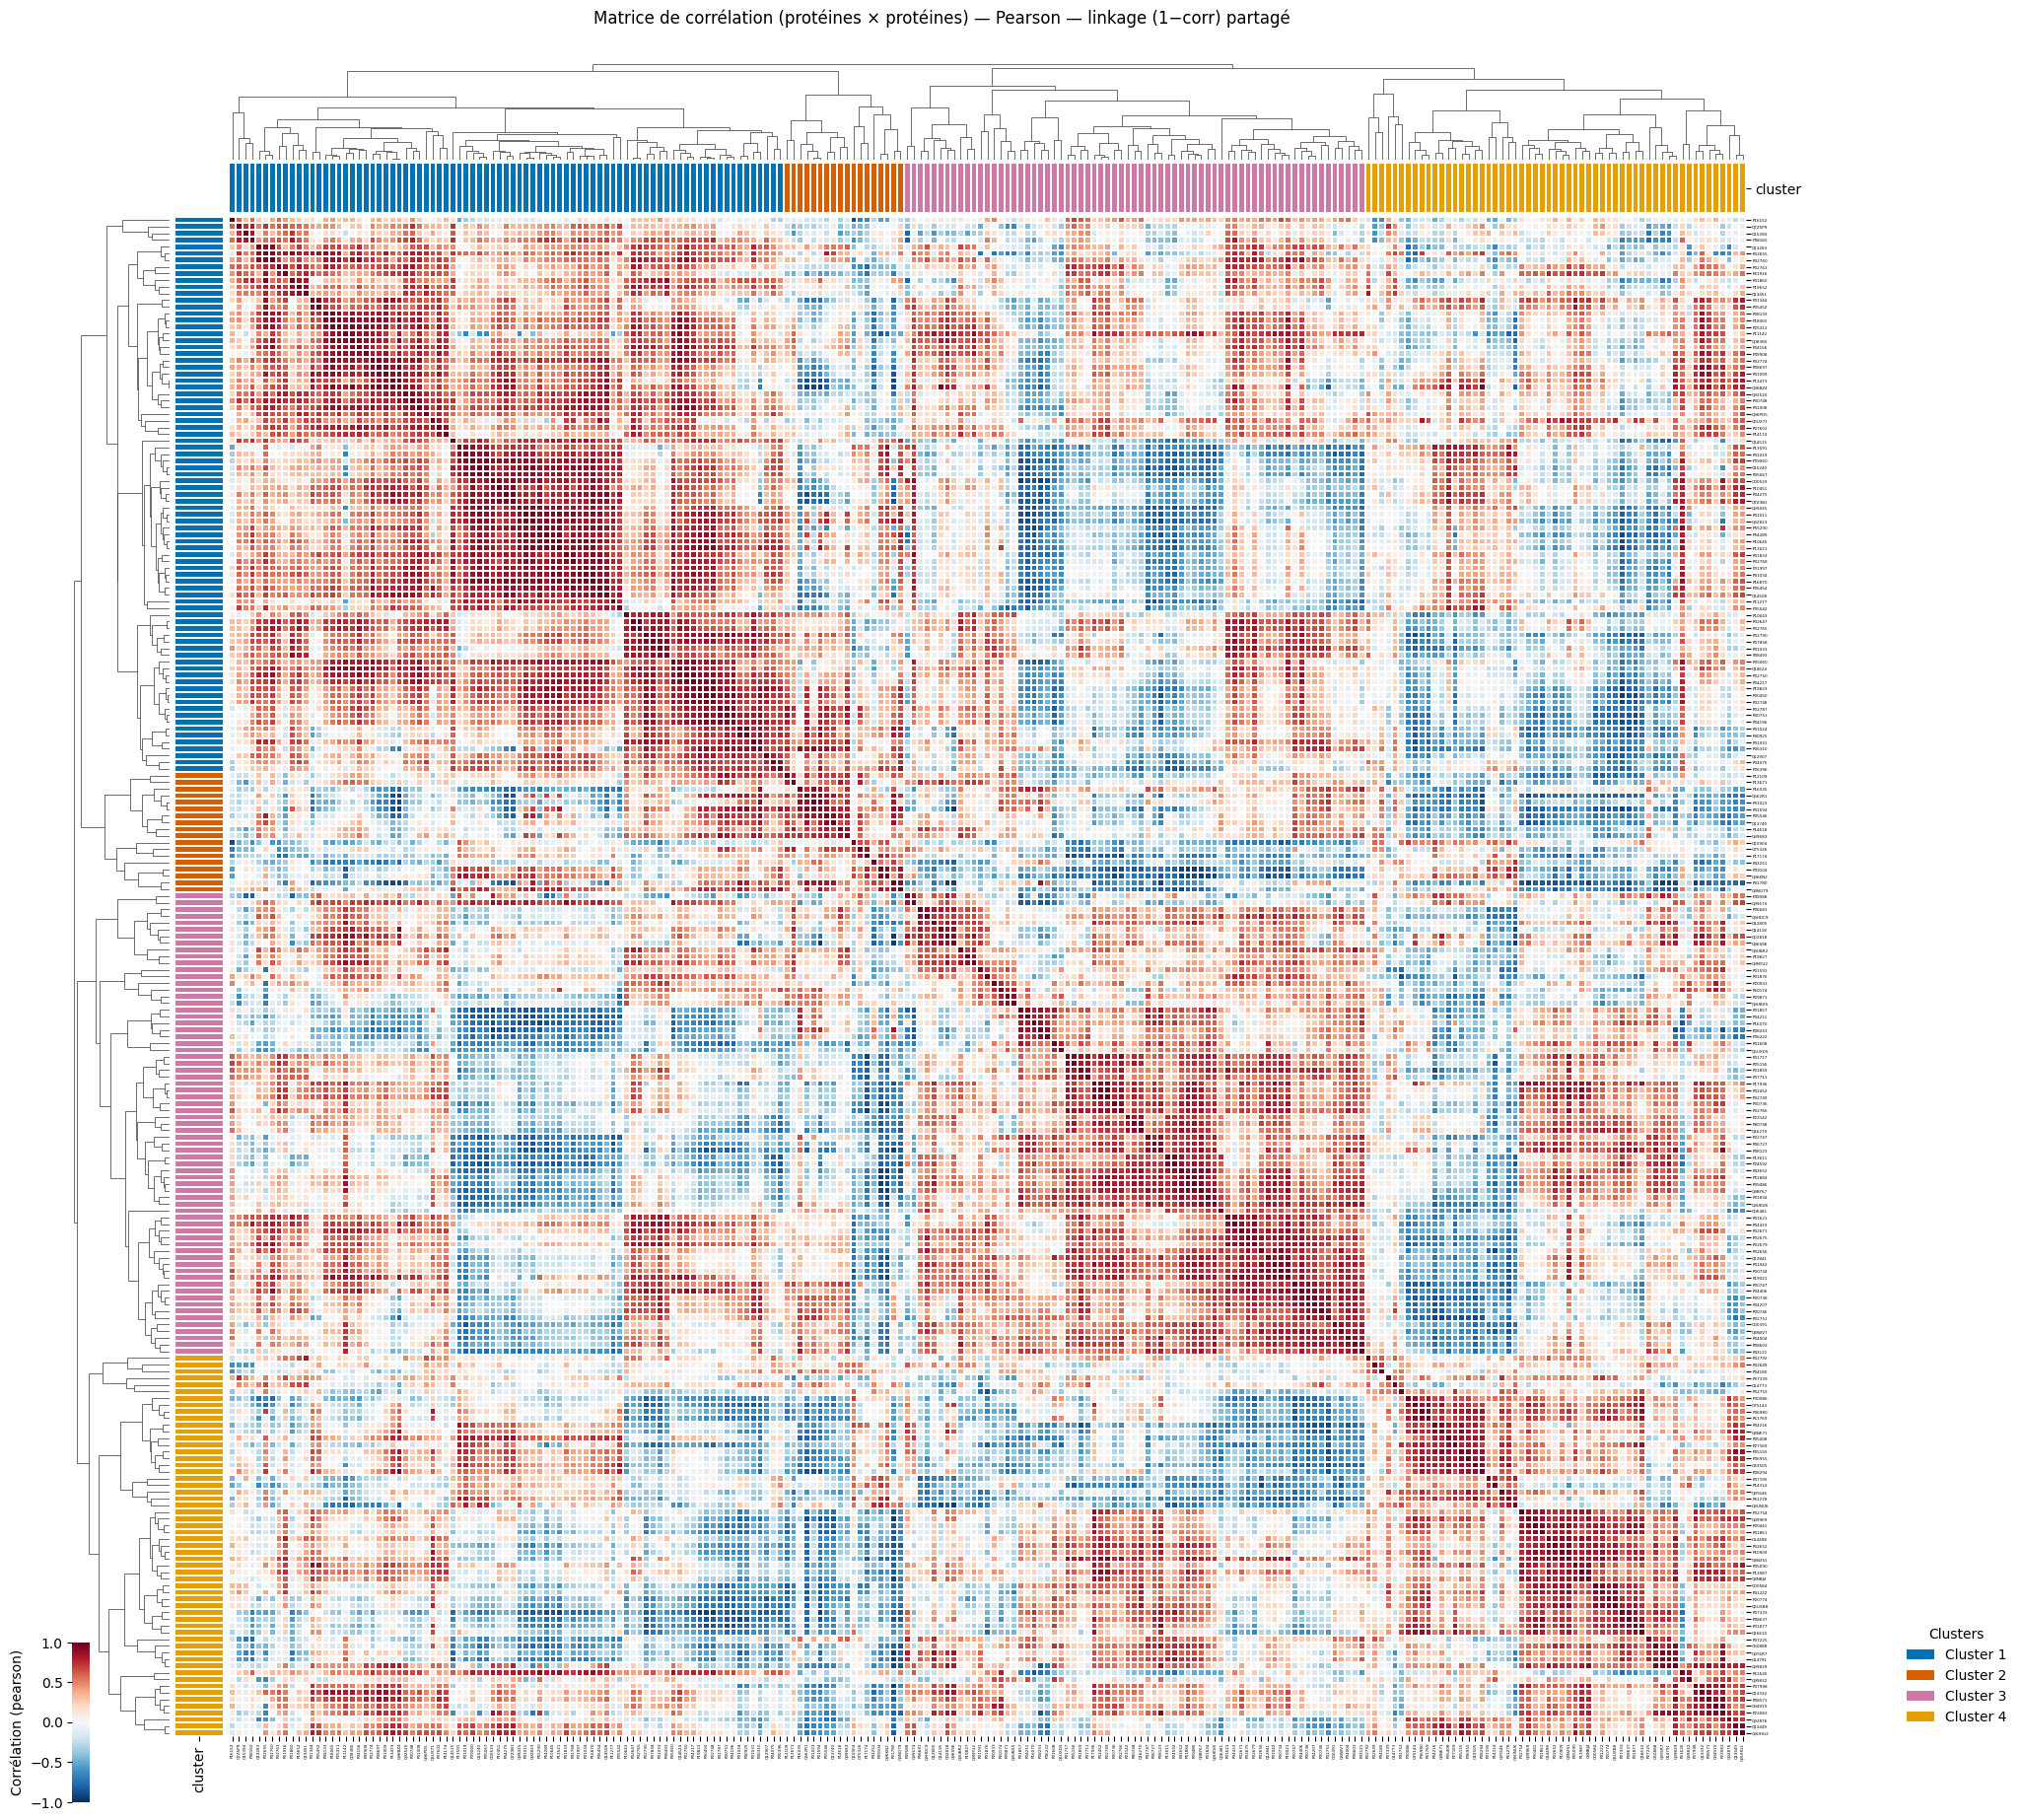

In [ ]:
# =========================
# IMPORTS (centralisés)
# =========================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display  # pour display(...)
from scipy import stats
from matplotlib.patches import Patch
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# =========================
# PARAMS / DATA
# =========================
# - train_proteins_pivot_labeled
# - train_proteins_pivot_labeled_mask_uprs_vectors
protein_cols = list(protein_cols)
PROTEINS = list(protein_cols)

# Fixer un ordre de mois (optionnel mais utile pour les plots/groupby)
if "visit_month" in train_proteins_pivot_labeled.columns:
    months_order = sorted(train_proteins_pivot_labeled["visit_month"].dropna().unique())
    train_proteins_pivot_labeled = train_proteins_pivot_labeled.copy()
    train_proteins_pivot_labeled["visit_month"] = pd.Categorical(
        train_proteins_pivot_labeled["visit_month"], ordered=True, categories=months_order
    )

# ===========================================================
# BAR PLOT : Nb total de valeurs manquantes (protéines) par mois
# ===========================================================
nan_total_by_month = (
    train_proteins_pivot_labeled
    .groupby("visit_month")[protein_cols]
    .apply(lambda g: g.isna().sum().sum())
    .reset_index(name="nb_total_NaN_proteins")
)

plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=nan_total_by_month,
    x="visit_month",
    y="nb_total_NaN_proteins",
    color="green"
)
plt.title("Nombre total de valeurs manquantes (NPX) par mois de visite", fontsize=10)
plt.xlabel("Mois de visite", fontsize=8)
plt.ylabel("Nombre total de valeurs manquantes", fontsize=8)
plt.xticks(rotation=45)
plt.grid(False)

# Annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=10,
        xytext=(0, 3), textcoords="offset points",
        color="black"
    )

plt.tight_layout()
plt.show()

# ===========================================================
# QQ-PLOTS (AVANT IMPUTATION) — 5 protéines les + manquantes
# ===========================================================
DF_RAW = train_proteins_pivot_labeled_mask_uprs_vectors.copy()
DF_RAW = DF_RAW.sort_values(["visit_month", "patient_id"]).reset_index(drop=True)

# Matrices brut / log / z-score (définies ICI pour être disponibles)
X = DF_RAW[PROTEINS].apply(pd.to_numeric, errors='coerce')
X_log = np.log1p(X)
mu = X_log.mean(axis=0)
sigma = X_log.std(axis=0, ddof=0).replace(0, np.nan)
X_scaled = (X_log - mu) / sigma

# Sélection top-5 NaN
na_counts = X.isna().sum()
proteins_with_nans = na_counts[na_counts > 0].sort_values(ascending=False)
N_QQ = 5
selected = list(proteins_with_nans.head(N_QQ).index)
print("Protéines avec NaN (top 5) et nombre de NaN :")
print(proteins_with_nans.head(N_QQ), "\n")

# Filtre : suffisamment d’observations
def enough_obs(M, col, min_n=8):
    return M[col].notna().sum() >= min_n

selected_valid = [p for p in selected if all(enough_obs(M, p) for M in (X, X_log, X_scaled))]
if len(selected_valid) == 0:
    raise ValueError("Aucune des protéines sélectionnées n’a ≥8 valeurs non-NaN dans toutes les versions (brut/log/z).")
if len(selected_valid) < len(selected):
    missing = sorted(set(selected) - set(selected_valid))
    print(f"⚠️ Ignorées (<8 valeurs utilisables dans au moins une version) : {missing}")
print(f"Protéines utilisées pour QQ-plot ({len(selected_valid)}) : {selected_valid}")

# Versions à comparer
versions = {
    "Brut": X,
    "Après log1p": X_log,
    "Après log1p + z-score": X_scaled,}

# Tracé QQ-plots
ncols = len(selected_valid)
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.2*ncols, 2.8*nrows), squeeze=False)
for i, (name, M) in enumerate(versions.items()):
    for j, prot in enumerate(selected_valid):
        ax = axes[i, j]
        s = M[prot].dropna()
        stats.probplot(s, dist="norm", plot=ax)
        if ax.get_lines():
            ax.get_lines()[0].set_markersize(2)
            if len(ax.get_lines()) > 1:
                ax.get_lines()[1].set_color("red")
        ax.set_title(f"{prot} — {name}", fontsize=9)
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.suptitle("QQ-plots (avant imputation) — 5 protéines les plus manquantes", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

# ===========================================================
# HEATMAP DE CORRÉLATION (PEARSON) PROTÉINE×PROTÉINE
# ===========================================================
corr_method = "pearson"
min_visits = 1

display("Données brutes (protéines × visites):", X)

# Profils moyens par visite -> (protéines × visites)
visit_profiles = (
    X_scaled
    .assign(visit_month=DF_RAW["visit_month"].values)
    .groupby("visit_month", observed=False)[PROTEINS]
    .mean()
    .T
).replace([np.inf, -np.inf], np.nan)
display("Transformation log1 + z-score — profils (protéines × visites):", visit_profiles)

# Corrélation des trajectoires
vp_corr_input = visit_profiles.loc[visit_profiles.notna().sum(axis=1) >= min_visits]
C = vp_corr_input.T.corr(method=corr_method, min_periods=min_visits)

# Nettoyage
C_use = (
    C.dropna(axis=0, how="all")
     .dropna(axis=1, how="all")
     .loc[lambda m: m.index.intersection(m.columns), lambda m: m.index.intersection(m.columns)]
)

# Clustering sur D=1-C
D = 1 - C_use.clip(-1, 1)
np.fill_diagonal(D.values, 0.0)
Z = linkage(squareform(D.values, checks=False), method="average")

# Seuil automatique
heights = np.sort(Z[:, 2])
if len(heights) >= 2:
    gaps = np.diff(heights)
    i = np.argmax(gaps)
    t_auto = (heights[i] + heights[i+1]) / 2.0
else:
    t_auto = 0.85

labels = fcluster(Z, t=t_auto, criterion="distance")
cluster_map = pd.Series(labels, index=C_use.index, name="cluster")
print(f"→ Clustering hiérarchique : t = {t_auto:.3f} | #clusters = {cluster_map.nunique()}")
print("Effectifs par cluster :")
print(cluster_map.value_counts().sort_index())

# Sauvegarde des assignations
cluster_map.reset_index().rename(columns={"index": "protein"}).to_csv(
    "protein_cluster_assignments_from_corr_vf.csv",
    index=False, encoding="utf-8-sig", sep=";", decimal=","
)

# Couleurs de clusters
labels_unique = np.sort(cluster_map.unique())
palette_fix = ["#0072B2", "#D55E00", "#CC79A7", "#E69F00", "#56B4E9", "#000000"]
palette = {lab: palette_fix[i % len(palette_fix)] for i, lab in enumerate(labels_unique)}
row_colors = cluster_map.map(palette)
col_colors = row_colors.reindex(C_use.columns)

# Clustermap en réutilisant Z
cg = sns.clustermap(
    C_use,
    row_linkage=Z, col_linkage=Z,
    cmap="RdBu_r", center=0, vmin=-1, vmax=1,
    figsize=(18, 18),
    linewidths=0.05,
    dendrogram_ratio=(.06, .06),
    xticklabels=1, yticklabels=1,
    row_colors=row_colors, col_colors=col_colors,
    cbar_kws={"label": f"Corrélation ({corr_method})"},)

# Légende des clusters
handles = [Patch(facecolor=palette[lab], label=f"Cluster {lab}") for lab in labels_unique]
cg.ax_heatmap.legend(handles=handles, title="Clusters", loc="lower right", bbox_to_anchor=(1.18, 0), frameon=False)

# Colorbar repositionnée
cbar = cg.ax_cbar
cbar.set_position([0.01, 0.01, 0.01, 0.09])
cbar.yaxis.set_ticks_position('left')
cbar.yaxis.set_label_position('left')

# Lisibilité
ax = cg.ax_heatmap
ax.tick_params(axis="x", labelsize=3, pad=1)
ax.tick_params(axis="y", labelsize=3, pad=1)
for lbl in ax.get_xticklabels(): lbl.set_rotation(90)
for lbl in ax.get_yticklabels(): lbl.set_rotation(0)

plt.suptitle(
    f"Matrice de corrélation (protéines × protéines) — {corr_method.capitalize()} — linkage (1−corr) partagé",
    y=1.02, fontsize=12
)
cg.savefig("Corr_Pearson_Matrice_Proteins_227_clusters_bf_imputation_vf.png", dpi=400, bbox_inches="tight")
plt.show()

### Imputation

In [ ]:
# =========================================================
# IMPUTATION HIERARCHIQUE en 3 étapes :
'''
1. Interpolation Linéaie intra-patient
2. Imputation par la médiane obtenus par les autres patients à la même visite
3. Imputation par la médiane de la protéine (toute visite confondue)'''
# =========================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

protein_cols = list(protein_cols)
PROTEINS = list(protein_cols)

# -----------------------------
# 0) Pré-contrôles
# -----------------------------
assert {"patient_id", "visit_month"}.issubset(train_proteins_pivot_labeled_mask_uprs_vectors.columns), \
    "Les colonnes 'patient_id' et 'visit_month' doivent être présentes."

# -----------------------------
# 1) Interpolation intra-patient
# -----------------------------
def _interp_patient(g, protein_cols):
    g = g.sort_values("visit_month").copy()
    for col in protein_cols:
        g[col] = g[col].interpolate(method="linear", limit_direction="both")
    return g
# -----------------------------
# 2) Pipeline d’imputation (SANS cluster)
# -----------------------------
def impute_pipeline_simple(df_in, protein_cols):
    """
    Imputation hiérarchique :
        (1) Interpolation intra-patient (linéaire)
        (2) Médiane inter-patients par visite (visit_month)
        (3) Médiane globale par protéine (filet final)
    """
    df = df_in.copy()
    df = df.sort_values(["patient_id", "visit_month"]).reset_index(drop=True)
    # Matrice protéines en numérique
    for c in protein_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # (1) Interpolation linéaire intra-patient
    df = df.groupby("patient_id", group_keys=False, observed=False)\
           .apply(lambda g: _interp_patient(g, protein_cols))

    # (2) Médiane inter-patients à la même visite
    visit_meds = df.groupby("visit_month", observed=False)[protein_cols].median()
    # Aligne chaque ligne sur la médiane de sa visite
    aligned_visit_meds = visit_meds.reindex(df["visit_month"].values).set_index(df.index)
    df[protein_cols] = df[protein_cols].fillna(aligned_visit_meds)

    # (3) Médiane globale par protéine
    glob_meds = df[protein_cols].median(axis=0)
    df[protein_cols] = df[protein_cols].fillna(glob_meds)

    return df
# -----------------------------
# 3) Application du pipeline d'imputation :
# -----------------------------
DF_IN = train_proteins_pivot_labeled_mask_uprs_vectors.copy()

nan_before = DF_IN[PROTEINS].isna().sum().sum()
DF_IMPUTED = impute_pipeline_simple(DF_IN, PROTEINS)
DF_IMPUTED.to_csv("DF_Proteines_Linear_IMPUTED_vf.csv", sep=";", decimal = "," , index=False, encoding="utf-8-sig")
nan_after  = DF_IMPUTED[PROTEINS].isna().sum().sum()

print(f"Protéines - NaN avant imputation : {nan_before:,}")
print(f"Protéines - NaN après  imputation : {nan_after:,}  (doit être 0)")

/tmp/ipython-input-379265524.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _interp_patient(g, protein_cols))


Protéines - NaN avant imputation : 19,168
Protéines - NaN après  imputation : 0  (doit être 0)


# Transformation Logarithmique et Scaling des données :

In [ ]:
## SCLAING DES DONNEES : ##

# ===========================================================
# TRANSFORMATION LOGARITHMIQUE + CENTRAGE-RÉDUCTION
# ===========================================================
import numpy as np
import pandas as pd

# Extraction de la matrice protéique
X = DF_IMPUTED[PROTEINS].apply(pd.to_numeric, errors="coerce")

# Transformation logarithmique (log1p = log(1+x)) -> stabilise la variance et réduit l'influence des valeurs extrêmes
X_log = np.log1p(X)

# Calcul des moyennes et écarts-types par protéine
mu = X_log.mean(axis=0)
sigma = X_log.std(axis=0, ddof=0).replace(0, np.nan)  # évite les divisions par 0

# Centrage-réduction (z-score)
X_scaled = (X_log - mu) / sigma

# Réintégration dans un DataFrame propre
DF_SCALED = DF_IMPUTED.copy()
DF_SCALED[PROTEINS] = X_scaled

# Sauvegarde du résultat
DF_SCALED.to_csv("DF_Proteines_Linear_Imputed_Scaled_vf.csv", sep=";", decimal=",", index=False, encoding="utf-8-sig")

print("✅ Transformation log1p + z-score effectuée avec succès.")
print(f"Dimensions du DataFrame transformé : {DF_SCALED.shape}")

✅ Transformation log1p + z-score effectuée avec succès.
Dimensions du DataFrame transformé : (1068, 238)


## Analyse exploratoire des données


### 2- Analyse univariées

**Statistiques générales :**

In [ ]:
import pandas as pd

# IMPORT DU DATAFRAME PROTEINES IMPUTE ET SCALED
DF_PROTEIN_IMP_SC = pd.read_csv("./DF_Proteines_Linear_Imputed_Scaled_vf.csv", sep = ";", decimal=",")

In [ ]:
DF_PROTEIN_IMP_SC[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].describe()

,updrs_1,updrs_2,updrs_3,updrs_4
count,1068.000000,1068.000000,1058.000000,569.000000
mean,6.566479,5.821161,17.300567,1.908612
std,5.330702,5.931414,15.016371,3.077419
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,0.000000
50%,5.000000,4.000000,16.000000,0.000000
75%,9.000000,9.000000,28.000000,3.000000
max,33.000000,29.000000,78.000000,20.000000


On observe qu'en moyenne les symptômes les plus sévères sont liées à la


In [ ]:
DF_PROTEIN_IMP_SC.groupby("visit_month")[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]].mean()

,updrs_1,updrs_2,updrs_3,updrs_4
visit_month,,,,
0,5.319588,4.103093,13.025773,1.787234
3,6.000000,5.000000,25.000000,NaN
6,6.505882,8.141176,24.000000,0.000000
12,6.433333,5.538889,16.471910,1.456311
18,4.875000,4.500000,7.857143,0.142857
24,6.687861,5.791908,16.652941,1.896552
30,14.000000,15.000000,29.000000,2.000000
36,7.414966,6.081633,17.904762,1.857143
48,6.890511,6.343066,18.397059,2.063158


<Axes: title={'center': 'Répartition des patients par mois de visite dans le dataframe DF Proteines Linear IMPUTED vf'}, xlabel='visit_month'>

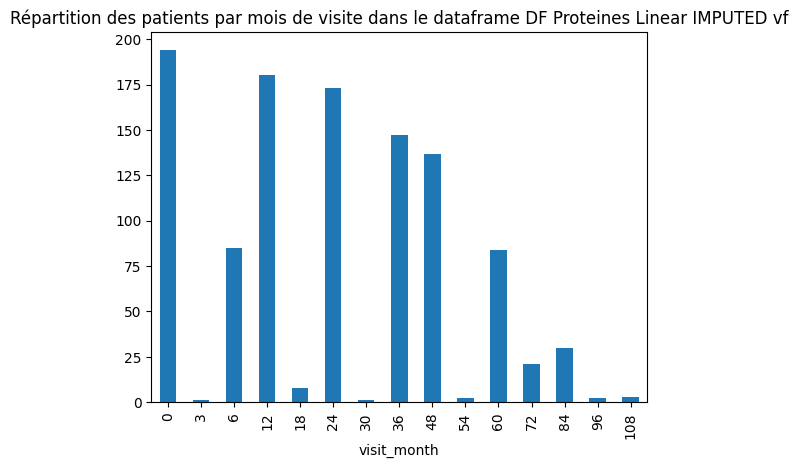

In [ ]:
DF_PROTEIN_IMP_SC["visit_month"].value_counts().sort_index().plot(
    kind="bar",
    title="Répartition des patients par mois de visite dans le dataframe DF Proteines Linear IMPUTED vf")

## Test statistique updrs_5

In [ ]:
grouped = train_proteins_pivot_labeled.groupby("patient_id")["upd23b_clinical_state_on_medication"].unique()

# 1. Identifier les patients toujours 'On' ou toujours 'Off'
id_patient_on = grouped[grouped.apply(lambda x: set(x) == {"On"})].index
id_patient_off = grouped[grouped.apply(lambda x: set(x) == {"Off"})].index

# 2. Extraire les scores updrs_3 pour chaque groupe
on_scores = train_proteins_pivot_labeled[train_proteins_pivot_labeled["patient_id"].isin(always_on_ids)]["updrs_3"].dropna()
off_scores = train_proteins_pivot_labeled[train_proteins_pivot_labeled["patient_id"].isin(always_off_ids)]["updrs_3"].dropna()

# 3. Condition de validité Student :
# a - Normalité des echantillons
# b - Egalité/homogénéité des variances

# a. Normalité
from scipy.stats import shapiro, levene
shapiro(on_scores)
#ShapiroResult(statistic=np.float64(0.9249556611490177),
# pvalue=np.float64(4.879698847427348e-05))
# <0.05, significativement différent, rejet de H0 -> pas de normalité

shapiro(off_scores)
#ShapiroResult(statistic=np.float64(0.9679182438724893),
#              pvalue=np.float64(0.6159312141933967))
# >0.05 , pas significativement différent de H0 -> normalité

# -> test non paramétrique

# b. Homogénéité des variances
levene(on_scores, off_scores)
#LeveneResult(statistic=np.float64(0.01945662831606523),
#             pvalue=np.float64(0.8893093056890273))
# >0.05 , pas significativement différent de H0 -> variance égale


# 4. Test de Mann–Whitney
from scipy.stats import mannwhitneyu

mannwhitneyu(on_scores, off_scores, alternative='two-sided')
# alternative='two-sided' : différence possible dans les deux directions
#MannwhitneyuResult(statistic=np.float64(1002.0),
#                   pvalue=np.float64(0.44319808136059036))
# > 0.05, différence non significative entre updrs_3 de 'On' et 'Off'
# H0 est rejetté
# la variable n'est pas pertinente à garder


## ACP

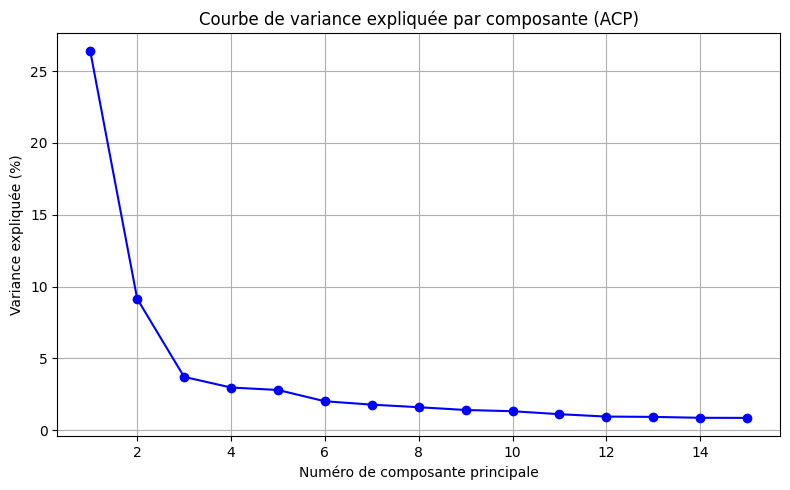

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraction des données protéiques
X_raw = DF_PROTEIN_IMP_SC.iloc[:,2:227].apply(pd.to_numeric, errors='coerce').fillna(0.0)

# 2. ACP complète
pca_full = PCA(n_components=15)
X_pca_full = pca_full.fit_transform(X_raw)

# 3. Courbe de variance expliquée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_ * 100,
         marker='o', linestyle='-', color='blue')
plt.title("Courbe de variance expliquée par composante (ACP)", fontsize=12)
plt.xlabel("Numéro de composante principale")
plt.ylabel("Variance expliquée (%)")
plt.grid(True)
plt.tight_layout()
plt.show()
# -> définir le nombre de composante à garder


1. CP1: P13987 CD 59 glycoprotéine

2. CP2: P02774 Vitamin D binding protein

Les variables les moins variables (exemple garder le top 80% selon la densité d'homogénéité) pourrait être retirées.


Variance expliquée (%) par composante:
  PC1: 26.33%
  PC2: 9.08%
  PC3: 3.70%
  PC4: 2.97%
  PC5: 2.78%
  PC6: 2.02%
Variance cumulée (PC1–PC6): 46.88%
Fichiers écrits : PCA6_scores.csv et PCA6_loadings.csv


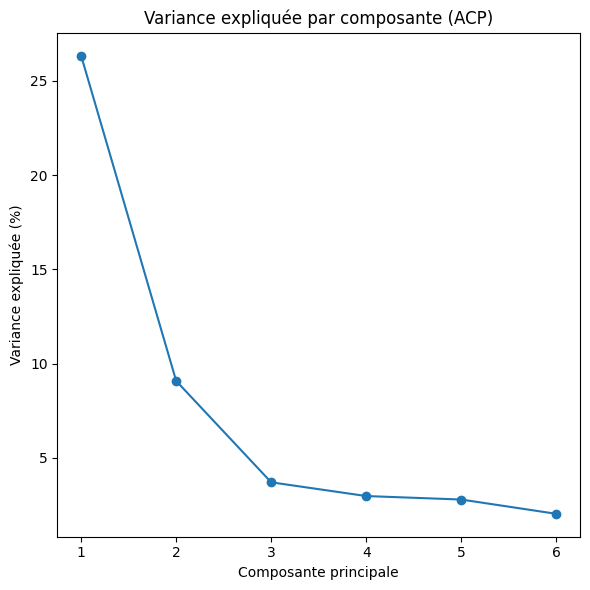

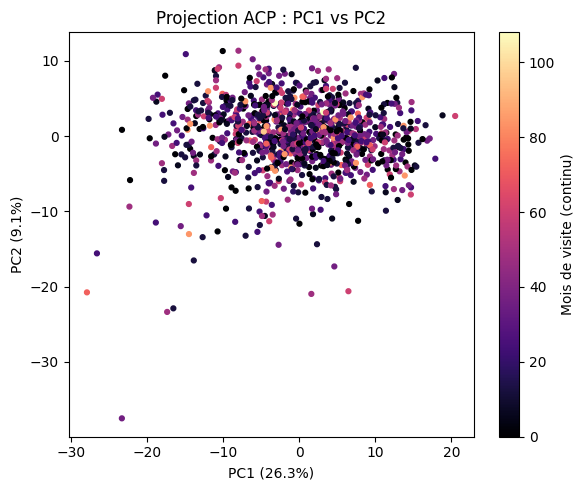

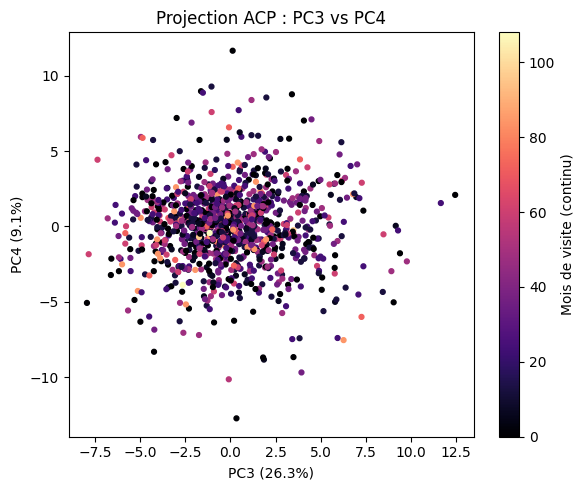

/tmp/ipython-input-661558925.py:110: UserWarning: Adding colorbar to a different Figure <Figure size 600x500 with 3 Axes> than <Figure size 600x500 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc); cbar.set_label("Mois de visite (continu)")


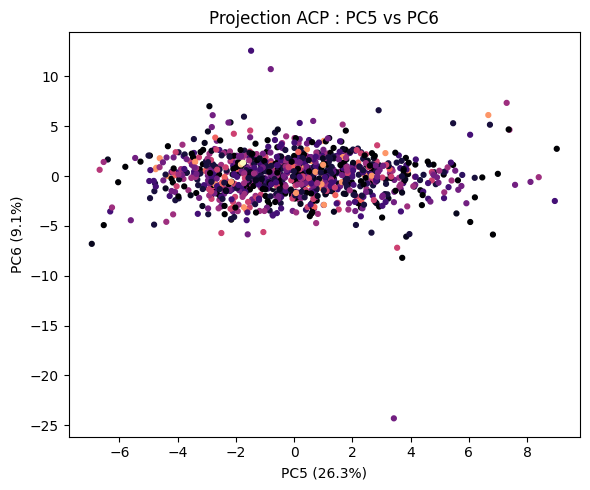


Top variables (|loading|) sur PC1:
 P13987    0.114462
O00533    0.112861
Q92823    0.111127
Q92520    0.110663
P10645    0.109495
P07602    0.108389
P04216    0.107906
Q8NBJ4    0.106037
P14618    0.105896
P14174    0.105774
P05452    0.105522
P13473    0.105012
Q13332    0.104493
P05067    0.103614
P17174    0.103582
Name: PC1, dtype: float64

Top variables (|loading|) sur PC2:
 P02774    0.177752
P00747    0.170513
P01042    0.164577
P02790    0.155209
P04217    0.153931
P01008    0.150497
P00751    0.146783
P02671    0.146759
P02749    0.144382
P02675    0.143602
P02647    0.142739
P00734    0.139966
P02652    0.137244
P01024    0.136742
P04004    0.135195
Name: PC2, dtype: float64


In [ ]:
# --- ACP à 6 composantes sur DF_PROTEIN_IMP_SC ---
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 0) Hypothèses: DF_PROTEIN_IMP_SC est un DataFrame déjà en mémoire
df = DF_PROTEIN_IMP_SC.copy()

# 1) Colonnes contextuelles (à exclure des features)
context_cols = {
    "patient_id", "visit_month",
    "updrs_1", "updrs_2", "updrs_3", "updrs_4",
    "upd23b_clinical_state_on_medication"
}

# 2) Sélection des colonnes protéines (numériques)
candidate_cols = [c for c in df.columns if c not in context_cols]
# garde uniquement les colonnes numériques (au cas où)
X = df[candidate_cols].apply(pd.to_numeric, errors="coerce")

# Si ton DF est bien "IMP_SC", il ne devrait pas y avoir de NaN. Par sécurité:
if X.isna().any().any():
    # choix safe: imputation par 0 (moyenne ~ 0 après z-score)
    X = X.fillna(0.0)

# 3) ACP à 6 composantes
pca = PCA(n_components=6, random_state=42)
scores = pca.fit_transform(X.values)

# 4) Variance expliquée
expl_var = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var)
print("Variance expliquée (%) par composante:")
for i, v in enumerate(expl_var, start=1):
    print(f"  PC{i}: {v*100:.2f}%")
print(f"Variance cumulée (PC1–PC6): {cum_var[-1]*100:.2f}%")

# 5) DataFrame des scores (PC1..PC6) + infos utiles
scores_df = pd.DataFrame(
    scores, columns=[f"PC{i}" for i in range(1, 7)],
    index=df.index
)
# Ajout d'infos de contexte si présentes
for c in ["patient_id", "visit_month"]:
    if c in df.columns:
        scores_df[c] = df[c].values

# 6) DataFrame des loadings (poids des variables)
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i}" for i in range(1, 7)]
)

# 7) Sauvegardes
scores_df.to_csv("PCA6_scores.csv", index=True)
loadings.reset_index().rename(columns={"index":"protein"}).to_csv("PCA6_loadings.csv", index=False)

print("Fichiers écrits : PCA6_scores.csv et PCA6_loadings.csv")

# 8) Figures (matplotlib uniquement)

# (a) Scree plot (PC1..PC6)
plt.figure(figsize=(6,6))
plt.plot(range(1,7), expl_var*100, marker='o')
plt.title("Variance expliquée par composante (ACP)")
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (%)")
plt.xticks([1,2,3,4,5,6])
plt.tight_layout()
plt.show()

# (b) Nuage PC1 vs PC2
plt.figure(figsize=(6,5))
sc = plt.scatter(scores_df["PC1"], scores_df["PC2"],
            c=pd.to_numeric(scores_df["visit_month"], errors="coerce"),
                 cmap="magma",
            s=12)
cbar = plt.colorbar(sc); cbar.set_label("Mois de visite (continu)")
plt.title("Projection ACP : PC1 vs PC2")
plt.xlabel(f"PC1 ({expl_var[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({expl_var[1]*100:.1f}%)")
plt.tight_layout()
plt.savefig(fname = "ACP_6comp_PC1vsPC2")
plt.show()


# (c) Nuage PC3 vs PC4
plt.figure(figsize=(6,5))
sc = plt.scatter(scores_df["PC3"], scores_df["PC4"],
                 c=pd.to_numeric(scores_df["visit_month"], errors="coerce"),
                 cmap="magma",
                 s=12)
cbar = plt.colorbar(sc); cbar.set_label("Mois de visite (continu)")
plt.title("Projection ACP : PC3 vs PC4")
plt.xlabel(f"PC3 ({expl_var[0]*100:.1f}%)")
plt.ylabel(f"PC4 ({expl_var[1]*100:.1f}%)")
plt.tight_layout()
plt.savefig(fname = "ACP_6comp_PC3vsPC4")
plt.show()


# (d) Nuage PC5 vs PC6
plt.figure(figsize=(6,5))
plt.scatter(scores_df["PC5"], scores_df["PC6"],
            c=pd.to_numeric(scores_df["visit_month"], errors="coerce"),
                 cmap="magma",
            s=12)
cbar = plt.colorbar(sc); cbar.set_label("Mois de visite (continu)")
plt.title("Projection ACP : PC5 vs PC6")
plt.xlabel(f"PC5 ({expl_var[0]*100:.1f}%)")
plt.ylabel(f"PC6 ({expl_var[1]*100:.1f}%)")
plt.tight_layout()
plt.savefig(fname = "ACP_6comp_PC5vsPC6")
plt.show()


# 9) (optionnel) Top variables contributrices à PC1 et PC2
top_k = 15
contrib_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(top_k)
contrib_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(top_k)
print("\nTop variables (|loading|) sur PC1:\n", contrib_pc1)
print("\nTop variables (|loading|) sur PC2:\n", contrib_pc2)

contrib_pc1.to_csv("top_var_acp_cp1.csv", index=True, encoding="utf-8-sig")
contrib_pc2.to_csv("top_var_acp_cp2.csv", index=True, encoding="utf-8-sig")


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Écrit : UMAP2D_scores.csv


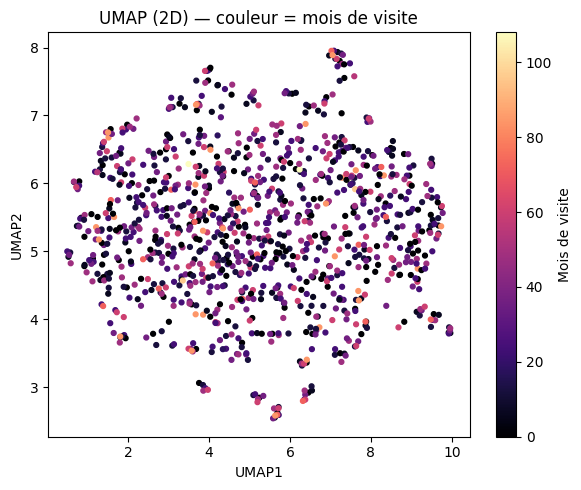

Figure : UMAP_visit_month.png


In [ ]:
# --- UMAP (2D) colorée par 'visit_month' ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0) Données
df = DF_PROTEIN_IMP_SC.copy()

# 1) Colonnes non-features à exclure (adapte si besoin)
context_cols = {
    "patient_id", "visit_month",
    "updrs_1", "updrs_2", "updrs_3", "updrs_4",
    "upd23b_clinical_state_on_medication"
}

# 2) X = features numériques (les protéines), y = visit_month
feature_cols = [c for c in df.columns if c not in context_cols]
X = df[feature_cols].apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(df["visit_month"], errors="coerce") if "visit_month" in df.columns else None

# 2bis) Sécurité : NaN -> 0 pour X (après z-score, 0 ~ moyenne)
if X.isna().any().any():
    X = X.fillna(0.0)

# Si 'visit_month' manquant pour certaines lignes, on les retire
if y is None:
    raise ValueError("La colonne 'visit_month' est absente du dataframe.")
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

# 3) UMAP
try:
    import umap  # pip install umap-learn
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "Le module 'umap-learn' est requis. Installe-le avec: pip install umap-learn"
    ) from e

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=0.2,     # ← à ajuster (0.0–0.5)
    metric="euclidean",
    random_state=42
)
embedding = umap_model.fit_transform(X.values)

# 4) Sauvegarde des coordonnées UMAP
umap_df = pd.DataFrame(
    {"UMAP1": embedding[:, 0], "UMAP2": embedding[:, 1], "visit_month": y.values},
    index=X.index
)
if "patient_id" in df.columns:
    umap_df["patient_id"] = df.loc[umap_df.index, "patient_id"].values

umap_df.to_csv("UMAP2D_scores.csv", index=False)
print("Écrit : UMAP2D_scores.csv")

# 5) Visualisation: gradient continu sur 'visit_month'
plt.figure(figsize=(6,5))
sc = plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], c=umap_df["visit_month"],
                 cmap = "magma", s=12)
plt.title("UMAP (2D) — couleur = mois de visite")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
cbar = plt.colorbar(sc)
cbar.set_label("Mois de visite")
plt.tight_layout()
plt.savefig("UMAP_visit_month.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure : UMAP_visit_month.png")

# (Optionnel) Hyperparamètre sweep rapide
# for nn in [10, 15, 30, 50]:
#     emb = umap.UMAP(n_neighbors=nn, min_dist=0.1, metric="euclidean", random_state=42).fit_transform(X.values)
#     plt.figure(figsize=(6,5))
#     sc = plt.scatter(emb[:,0], emb[:,1], c=y.values, s=10)
#     plt.title(f"UMAP — n_neighbors={nn}")
#     plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
#     plt.colorbar(sc, label="Mois de visite")
#     plt.tight_layout(); plt.show()


In [ ]:
print(DF_PROTEIN_IMP_SC.head())
DF_PROTEIN_IMP_SC.to_csv("DF_Prot_imp_sc_updrstotal.csv", sep=";", decimal = "," , index=False, encoding="utf-8-sig")

   patient_id  visit_month   O00391    O00533   O00584   O14498    O14773  \
0          55            0  11254.3  732430.0  39585.8  41526.9  31238.00   
1          55            6  13163.6  630465.0  35220.8  41295.0  26219.90   
2          55           12  15257.6  815083.0  41650.9  39763.3  30703.60   
3          55           36  13530.8  753832.0  43048.9  43503.6  33577.60   
4         942            6  11218.7  399518.0  20581.0  31290.9   6173.58   

    O14791    O15240   O15394  ...  updrs_1  updrs_2  updrs_3  updrs_4  \
0  4202.71  177775.0  62898.2  ...     10.0      6.0     15.0      NaN   
1  4416.42  165638.0  62567.5  ...      8.0     10.0     34.0      NaN   
2  4343.60  151073.0  66963.1  ...     10.0     10.0     41.0      0.0   
3  5367.06  101056.0  67588.6  ...     17.0     18.0     51.0      0.0   
4  2564.37  160526.0  43423.1  ...      8.0      2.0     21.0      NaN   

   upd23b_clinical_state_on_medication  updrs_1_mask  updrs_2_mask  \
0                     

In [ ]:
# === Quantifier l'association UPDRS ↔ position UMAP ===
import pandas as pd, numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors

# Reprend l'UMAP sauvegardée

U = pd.read_csv("UMAP_bins_scores_UPDRS.csv")  # contient UMAP1, UMAP2, updrs_total

U = U.dropna(subset=["UMAP1","UMAP2","updrs_total"])
X2 = U[["UMAP1","UMAP2"]].values
y  = pd.to_numeric(U["updrs_total"], errors="coerce").values

# 1) Corrélation monotone avec chaque axe
rho1,p1 = spearmanr(U["UMAP1"], y)
rho2,p2 = spearmanr(U["UMAP2"], y)
print(f"Spearman(UMAP1, UPDRS) = {rho1:.3f} (p={p1:.1e})")
print(f"Spearman(UMAP2, UPDRS) = {rho2:.3f} (p={p2:.1e})")

# 2) Prédictibilité locale (kNN sur l'espace UMAP) : si R²>0, il existe une structure locale
knn = KNeighborsRegressor(n_neighbors=15, weights="distance")
cv  = KFold(n_splits=5, shuffle=True, random_state=42)
r2  = cross_val_score(knn, X2, y, cv=cv, scoring="r2")
print(f"kNN R² (CV 5-fold) = {r2.mean():.3f} ± {r2.std():.3f}")

# 3) Autocorrélation spatiale (Moran's I) sur la carte UMAP
k=15
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X2)
_, idx = nbrs.kneighbors(X2)
n = len(y)
W = np.zeros((n,n))
for i, row in enumerate(idx):
    for j in row[1:]:
        W[i,j] = 1
W = W + W.T  # symétriser
z = y - y.mean()
num = float((W * np.outer(z,z)).sum())
den = float((z**2).sum())
I = (n/W.sum()) * (num/den)
print(f"Moran's I (k={k}) = {I:.3f}")


Spearman(UMAP1, UPDRS) = -0.002 (p=9.9e-01)
Spearman(UMAP2, UPDRS) = 0.117 (p=1.9e-01)
kNN R² (CV 5-fold) = -0.094 ± 0.074
Moran's I (k=15) = 0.013


## Model development

This section focuses on model development, including a Multilayer Perceptron (MLP) and a Random Forest regressor.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential # Commented out for debugging
from tensorflow.keras.optimizers import RMSprop, Adam # Commented out for debugging
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout # Commented out for debugging
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import ydf

### Subset by month visit

For the prediction, we created a subset by month visit. Because of limited resources, we chose to train the models with only one target month, preferably one with few missing data.

In [ ]:
# --------------------------
# Filter visit months with variable UPDRS
# --------------------------
all_months = [0,3,6,9,12,18,24,30,36,42,48,54,60]
updrs_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']

visit_months_filtered = []
for month in all_months:
    subset = df[df['visit_month'] == month]
    variances = subset[updrs_cols].var()
    if (variances > 1e-5).any():  # keep month if at least one UPDRS varies
        visit_months_filtered.append(month)

print("Filtered visit months:", visit_months_filtered)

In [ ]:
# --------------------------
# Select a visit month (random or first variable)
# --------------------------
visit_month_target = np.random.choice(visit_months_filtered)
print(f"Selected target visit month: {visit_month_target}")

In [ ]:
# --------------------------
# Create target dataset
# --------------------------
protein_cols = [col for col in df.columns if col.startswith("NPX_")]

target_month_df = df[df['visit_month'] == visit_month_target].copy()

if visit_month_target > 0:
    # Include historical features: mean NPX from previous months
    history_df = df[df['visit_month'] < visit_month_target]
    history_features = history_df.groupby('patient_id')[protein_cols].mean()
    target_df = target_month_df.merge(history_features, on='patient_id', suffixes=('', '_hist'))
else:
    target_df = target_month_df.copy()

### First model : Multi Layer Perceptron (MLP)

We selected the MLP for this dataset as it is capable of modeling complex non-linear relationships, which appeared appropriate given the biological context. We only tested it on data with median imputation.

#### Features and labels

In [ ]:
# --------------------------
# Features and labels
# --------------------------
X_cols = protein_cols + [c + '_hist' for c in protein_cols if visit_month_target > 0]
y_cols = updrs_cols

X = target_df[X_cols].values
y = target_df[y_cols].values

# Remove rows with NaN in y
mask = ~np.isnan(y).any(axis=1)
X = X[mask]
y = y[mask]

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Build MLP model

In [ ]:
# --------------------------
# MLP model
# --------------------------
mlp = Sequential()
mlp.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dropout(0.3))
mlp.add(Dense(4, activation='linear'))  # 4 outputs for 4 UPDRS

mlp.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])
mlp.summary()

#### Training

In [ ]:
# --------------------------
# Training
# --------------------------
mlp_history = mlp.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

#### Prediction and metrics

In [ ]:
# --------------------------
# Predictions & metrics
# --------------------------
y_pred = mlp.predict(X_test)

In [ ]:
# Metrics per UPDRS
for i, updrs in enumerate(y_cols):
    mae = mean_absolute_error(y_test[:,i], y_pred[:,i])
    mse = mean_squared_error(y_test[:,i], y_pred[:,i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[:,i], y_pred[:,i])
    print(f"{updrs} --> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

In [ ]:
# --------------------------
# Metrics visualization
# --------------------------
plt.figure(figsize=(12,5))
plt.plot(mlp_history.history['loss'], label='Train MSE')
plt.plot(mlp_history.history['val_loss'], label='Val MSE')
plt.plot(mlp_history.history['mae'], label='Train MAE')
plt.plot(mlp_history.history['val_mae'], label='Val MAE')
plt.title(f"Training metrics (month {visit_month_target})")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()

In [ ]:
# Correlation matrix
corr_matrix = pd.DataFrame(np.hstack([y_test, y_pred]),
                           columns=['updrs1_true','updrs2_true','updrs3_true','updrs4_true',
                                    'updrs1_pred','updrs2_pred','updrs3_pred','updrs4_pred']).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(f"Correlation matrix (month {visit_month_target})")
plt.show()

In [ ]:
# Scatter plots y_true vs y_pred
plt.figure(figsize=(12,10))
for i, col in enumerate(updrs_cols, 1):
    plt.subplot(2,2,i)

    y_t = y_test[:, i-1]
    y_p = y_pred[:, i-1]

    # Prédiction moyenne pour comparaison
    y_mean = np.full_like(y_t, y_t.mean())

    plt.scatter(y_t, y_p, alpha=0.6, label='MLP predictions')
    plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], 'r--', label='Perfect prediction')
    plt.plot([y_t.min(), y_t.max()], [y_mean.min(), y_mean.max()], 'g:', label='Mean benchmark')

    plt.title(f'{col}: True vs Predicted')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Optionnel : calcul de MAE/RMSE pour la baseline moyenne
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("=== Baseline (mean) metrics ===")
for i, col in enumerate(updrs_cols):
    y_t = y_test[:, i]
    y_mean = np.full_like(y_t, y_t.mean())
    mae = mean_absolute_error(y_t, y_mean)
    mse = mean_squared_error(y_t, y_mean)
    rmse = np.sqrt(mse) # Calculate RMSE by taking the square root of MSE
    print(f"{col} --> MAE: {mae:.3f}, RMSE: {rmse:.3f}")

Given the performance metrics, the model seems unable to learn meaningful patterns from the data.

### Second model : Random Forest (RF)

Next, we evaluated a Random Forest regressor, as the objective was to predict a continuous variable. Given its robustness to noise and limited sample sizes, this model served as a suitable benchmark for comparison.


We wanted to compare both strategies : with median imputation, and with linear interpolation, before every split or cross validation.

#### RF tested on data with median imputation

##### Features and labels

In [ ]:
# Select a target visit month (e.g., month 24, or make it a variable)
visit_month_target = 24 # Example target month, you might want to change this or make it a variable

# Filter data for the target month
target_month_df = df[df['visit_month'] == visit_month_target].copy()

# Add historical features if they exist (protein_cols assumed to be defined from df)
protein_cols = [col for col in df.columns if col.startswith("NPX_")]
if visit_month_target > 0:
    history_df = df[df['visit_month'] < visit_month_target]
    # Select only protein columns that exist in history_df
    history_protein_cols = [col for col in protein_cols if col in history_df.columns]
    if history_protein_cols:
        history_features = history_df.groupby('patient_id')[history_protein_cols].mean()
        target_df = target_month_df.merge(history_features, on='patient_id', suffixes=('', '_hist'))
    else:
        target_df = target_month_df.copy()
        print(f"No historical protein data found for months before {visit_month_target}")
else:
    target_df = target_month_df.copy()

In [ ]:
# --------------------------
# Random Forest YDF with correlation and scatter plots (train/test split)
# --------------------------
rf_models = {}

# Define y_cols here
updrs_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']
y_cols = updrs_cols

# Prepare features dataframe
features_df = target_df.pivot_table(index=['patient_id', 'visit_month'],
                                    columns='UniProt', values='NPX_log')

# Add historical features if they exist
# This part is already handled during target_df creation, so we can remove the redundant merge
# if visit_month_target > 0:
#     history_df = df[df['visit_month'] < visit_month_target]
#     history_features = history_df.groupby('patient_id')[protein_cols].mean()
#     features_df = features_df.merge(history_features, left_on='patient_id', right_index=True, suffixes=('', '_hist'))

features_df = features_df.reset_index()

# Prepare labels dataframe
labels_df = target_df.groupby(['patient_id', 'visit_month'])[y_cols].first().reset_index()

# Merge features and labels
dataset_df = pd.merge(features_df, labels_df, on=['patient_id', 'visit_month'])
dataset_df = dataset_df.dropna(subset=y_cols)

# Filter out UPDRS columns with almost no variance
var_threshold = 0.01
y_variances = dataset_df[y_cols].var()
valid_y_cols = [col for col in y_cols if y_variances[col] > var_threshold]
print(f"UPDRS columns with sufficient variance: {valid_y_cols}")

##### Training with simple train/test split : 0.8/0.2 (by patient)

In [ ]:
# --------------------------
# Split train/test (by patient)
# --------------------------
unique_patients = dataset_df['patient_id'].unique()
# Check if there are enough unique patients for splitting
if len(unique_patients) < 2:
    print(f"Skipping training due to insufficient unique patients ({len(unique_patients)}) for train/test split.")
else:
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

    train_df = dataset_df[dataset_df['patient_id'].isin(train_patients)].copy()
    test_df  = dataset_df[dataset_df['patient_id'].isin(test_patients)].copy()

    print(f"Train patients: {len(train_patients)}, Test patients: {len(test_patients)}")
    print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

    # Check if train_df and test_df are empty after splitting
    if train_df.empty or test_df.empty:
        print("Skipping training due to empty train or test set after splitting.")
    else:
        # --------------------------
        # Training and evaluation
        # --------------------------
        pred_dict = {}
        true_dict = {}

        for col in valid_y_cols:
            print(f"\n=== Training Random Forest for {col} ===")

            # Prepare YDF-compatible dataframes
            train_X = train_df.drop(columns=['patient_id', 'visit_month'] + y_cols)
            train_y = train_df[col]

            test_X = test_df.drop(columns=['patient_id', 'visit_month'] + y_cols)
            test_y = test_df[col]

            # Train Random Forest on train set only
            df_train_ydf = train_X.copy()
            df_train_ydf[col] = train_y.values

            # Check if training data for this UPDRS column has variance
            if np.var(train_y) < 1e-6:
                print(f"Skipping training for {col} due to zero variance in training data.")
                continue

            rf = ydf.RandomForestLearner(label=col, task=ydf.Task.REGRESSION).train(df_train_ydf)
            rf_models[col] = rf

            # Predict on test set only
            preds = rf.predict(test_X)

            # Store for correlation
            pred_dict[col] = preds
            true_dict[col] = test_y.values

            # Metrics
            mae = mean_absolute_error(test_y, preds)
            mse = mean_squared_error(test_y, preds)
            rmse = np.sqrt(mse)
            r2 = r2_score(test_y, preds)

            print(f"Random Forest ({col}) --> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

        # Note: Scatter plots and correlation matrix are not generated in this cell based on the original code structure,
        # but you could add them here using pred_dict and true_dict if needed after the loop.

##### Prediction and metrics for the split

In [ ]:
# --------------------------
# Scatter plot of true vs predicted
# --------------------------
plt.figure(figsize=(8,8))
colors = sns.color_palette("tab10", n_colors=len(valid_y_cols))
for i, col in enumerate(valid_y_cols):
    plt.scatter(true_dict[col], pred_dict[col], label=col, color=colors[i])

# Determine plot limits from true and predicted values
all_true_values = np.concatenate([true_dict[col] for col in valid_y_cols])
all_pred_values = np.concatenate([pred_dict[col] for col in valid_y_cols])

min_val = min(all_true_values.min(), all_pred_values.min())
max_val = max(all_true_values.max(), all_pred_values.max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel("True UPDRS")
plt.ylabel("Predicted UPDRS")
plt.title(f"Random Forest Predictions (month {visit_month_target})")
plt.legend()
plt.show()


def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error
    y_true, y_pred : arrays de même shape
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    # On évite la division par 0
    mask = denominator != 0
    return 100 * np.mean(2 * numerator[mask] / denominator[mask])

# Use predictions from the Random Forest model (from pred_dict and true_dict)
for col in valid_y_cols:
    print(f"{col} SMAPE = {smape(true_dict[col], pred_dict[col]):.2f}")

##### Training with 5-fold cross validation

In [ ]:
# Check if there are enough samples for cross-validation
if len(dataset_df) < KFold(n_splits=5).get_n_splits():
    print(f"Skipping cross-validation for month {visit_month_target} due to insufficient samples ({len(dataset_df)}) for 5 splits.")
else:
    # --------------------------
    # Cross-validation
    # --------------------------
    rf_models = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_cols = [c for c in dataset_df.columns if c.startswith('NPX_')] # Updated X_cols to select protein features
    X_all = dataset_df[X_cols].values

    # Dictionaries to store predictions and true values across all folds for plotting
    pred_dict = {col: [] for col in valid_y_cols}
    true_dict = {col: [] for col in valid_y_cols}


    for col in valid_y_cols:
        y_all = dataset_df[col].values
        fold_mae, fold_rmse, fold_r2 = [], [], []

        # Check if there are enough samples for cross-validation for this specific UPDRS column
        if len(y_all) < kf.n_splits:
            print(f"Skipping CV for {col} in month {visit_month_target} due to insufficient samples ({len(y_all)}) for {kf.n_splits} splits.")
            continue


        for train_idx, test_idx in kf.split(X_all):
            X_train, X_test = X_all[train_idx], X_all[test_idx]
            y_train, y_test = y_all[train_idx], y_all[test_idx]

            # Check variance of the target variable in the training set
            if np.var(y_train) < 1e-6: # Use a small threshold for floating point comparisons
                print(f"Skipping training for {col} in a fold due to zero variance in training data.")
                continue


            # Prepare dataframes for YDF
            # Ensure column names for YDF training
            df_train_ydf = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
            df_train_ydf[col] = y_train

            df_test_ydf = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])


            # Train Random Forest
            rf = ydf.RandomForestLearner(label=col, task=ydf.Task.REGRESSION).train(df_train_ydf)
            # rf_models[col] = rf # commented out as rf_models is not used later

            preds = rf.predict(df_test_ydf)

            # Ensure preds and y_test are arrays before extending
            preds_array = np.array(preds)
            y_test_array = np.array(y_test)


            # Metrics
            mae = mean_absolute_error(y_test_array, preds_array)
            rmse = np.sqrt(mean_squared_error(y_test_array, preds_array))
            r2 = r2_score(y_test_array, preds_array)
            fold_mae.append(mae)
            fold_rmse.append(rmse)
            fold_r2.append(r2)

            # Store predictions for scatter - ensure arrays have at least one dimension
            pred_dict[col].extend(preds_array.flatten()) # Flatten to ensure 1D list of values
            true_dict[col].extend(y_test_array.flatten()) # Flatten to ensure 1D list of values


            # Libération RAM
            del rf, preds, df_train_ydf, df_test_ydf, preds_array, y_test_array
            gc.collect()

        # Only print average metrics if any folds were trained
        if fold_mae:
            print(f"\nRandom Forest ({col}) - CV results over {len(fold_mae)} folds:")
            print(f"MAE: {np.mean(fold_mae):.3f} ± {np.std(fold_mae):.3f}")
            print(f"RMSE: {np.mean(fold_rmse):.3f} ± {np.std(fold_rmse):.3f}")
            print(f"R²: {np.mean(fold_r2):.3f} ± {np.std(fold_r2):.3f}")
        else:
             print(f"\nRandom Forest ({col}) - No folds trained due to zero variance in training data.")

##### Prediction and metrics for the 5-fold CV

In [ ]:
    # --------------------------
    # SMAPE
    # --------------------------
    def smape(y_true, y_pred):
        numerator = np.abs(y_pred - y_true)
        denominator = np.abs(y_true) + np.abs(y_pred)
        mask = denominator != 0
        return 100 * np.mean(2 * numerator[mask] / denominator[mask])

    for col in valid_y_cols:
        # Calculate SMAPE only if there are data points
        # Ensure the lists are not empty before converting to numpy array
        if true_dict[col]:
            print(f"{col} SMAPE = {smape(np.array(true_dict[col]), np.array(pred_dict[col])):.2f}")
        else:
            print(f"{col} SMAPE: Not calculated due to no data points from CV folds.")


    # --------------------------
    # Scatter plots
    # --------------------------
    for col in valid_y_cols:
        # Ensure the lists are not empty before converting to numpy array
        if true_dict[col]:
            y_true = np.array(true_dict[col])
            y_pred = np.array(pred_dict[col])
            # Only generate scatter plot if there are data points
            if len(y_true) > 0:
                plt.figure(figsize=(6,6))
                sns.scatterplot(x=y_true, y=y_pred)
                # Ensure plot range is based on actual data
                min_val = min(y_true.min(), y_pred.min())
                max_val = max(y_true.max(), y_pred.max())
                plt.plot([min_val, max_val],
                         [min_val, max_val],
                         'r--', lw=2)
                plt.xlabel("True " + col)
                plt.ylabel("Predicted " + col)
                plt.title(f"Scatter plot: {col} - Target month {visit_month_target} (CV)")
                plt.grid(True)
                plt.show()
            else:
                 print(f"No data to plot for {col} in month {visit_month_target} (CV).")
        else:
             print(f"No data to plot for {col} in month {visit_month_target} (CV) due to no data points from CV folds.")


    # --------------------------
    # Correlation matrix
    # --------------------------
    # Only generate correlation matrix if there are data points
    # Ensure the lists are not empty before converting to numpy array
    # Restructure the dictionary comprehension for clarity and correctness
    corr_data = {}
    for col in valid_y_cols:
        # Ensure lists are not empty before attempting concatenation
        if true_dict[col] and pred_dict[col]:
            corr_data[f"{col}_true"] = np.array(true_dict[col])
            corr_data[f"{col}_pred"] = np.array(pred_dict[col])

    # Create DataFrame only if there's actual data
    if corr_data: # Check if the corr_data dictionary is not empty
        # Ensure all arrays in corr_data have the same length before creating DataFrame
        if len(set(len(arr) for arr in corr_data.values())) == 1:
            corr_df = pd.DataFrame(corr_data)
            corr_matrix = corr_df.corr()
            plt.figure(figsize=(10,8))
            sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
            plt.title(f"Correlation matrix (Month {visit_month_target}) (CV)")
            plt.show()
        else:
            print(f"\nNo correlation matrix to generate for month {visit_month_target} (CV) due to inconsistent array lengths.")
    else:
        print(f"\nNo correlation matrix to generate for month {visit_month_target} (CV) due to no data points from CV folds for any valid UPDRS columns.")


# For RAM
del target_month_df, target_df, dataset_df, X_all, y_all
# Ensure pred_dict and true_dict are deleted only if they exist
if 'pred_dict' in locals():
    del pred_dict
if 'true_dict' in locals():
    del true_dict
if 'corr_df' in locals():
    del corr_df
if 'corr_matrix' in locals():
    del corr_matrix
if 'corr_data' in locals(): # Also delete corr_data
    del corr_data
gc.collect()

Given the metrics on split and CV, the model is unable to learn properly. A data leakage problem was identified, resulting from imputing the data prior to performing the train-test split or cross-validation.

The same issue can be observed in the following strategy.

#### RF tested on data with linear interpolation

Features and labels are the same as before.

##### Training with simple train/test split : 0.8/0.2 (by patient)

In [ ]:
# --------------------------
# SMAPE
# --------------------------
def smape(y_true, y_pred):
    """
    Calculates la Symmetric Mean Absolute Percentage Error (SMAPE)
    between y_true et y_pred.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / np.maximum(denominator, 1e-8)
    return 100 * np.mean(diff)


# --------------------------
# Fonction pour entraîner et évaluer le Random Forest
# --------------------------
def evaluate_rf(df, dataset_name):
    print(f"\n=== Results for {dataset_name} ===")

    # Convert UPDRS columns to numeric, handling commas and potential errors
    for col in updrs_cols:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # keep only useful columns
    protein_cols = [c for c in df.columns if c.startswith('P') or c.startswith('O')]
    keep_cols = ['patient_id', 'visit_month'] + updrs_cols + protein_cols
    df[protein_cols] = df[protein_cols].apply(pd.to_numeric, errors='coerce')
    df = df[keep_cols].dropna(subset=updrs_cols)

    rf_models = {}
    metrics = []
    pred_dict = {}
    true_dict = {}

    # Split per patient_id (80/20)
    patient_ids = df['patient_id'].unique()
    train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
    df_train = df[df['patient_id'].isin(train_ids)]
    df_test = df[df['patient_id'].isin(test_ids)]

    for col in updrs_cols:
        # train
        current_train = df_train.drop(columns=['patient_id', 'visit_month']).copy()
        current_test = df_test.drop(columns=['patient_id', 'visit_month']).copy()

        rf = ydf.RandomForestLearner(label=col, task=ydf.Task.REGRESSION).train(current_train)
        rf_models[col] = rf

        # Predictions
        preds = rf.predict(current_test)
        true_vals = current_test[col].values

        # Stock
        pred_dict[col] = preds
        true_dict[col] = true_vals

        # Metrics
        mae = mean_absolute_error(true_vals, preds)
        mse = mean_squared_error(true_vals, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(true_vals, preds)
        smape_val = smape(true_vals, preds)

        metrics.append((col, mae, rmse, r2, smape_val))
        print(f"UPDRS {col[-1]} --> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}, SMAPE: {smape_val:.2f}%")

        # Scatter plot True vs Predicted
        plt.figure(figsize=(5,5))
        plt.scatter(true_vals, preds, alpha=0.5)
        plt.plot([min(true_vals), max(true_vals)], [min(true_vals), max(true_vals)], 'r--')
        plt.xlabel("True UPDRS")
        plt.ylabel("Predicted UPDRS")
        plt.title(f"{dataset_name} - {col} (R²={r2:.2f})")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(metrics, columns=["UPDRS", "MAE", "RMSE", "R2", "SMAPE"])

##### Prediction and metrics for the split

Here, I compared results between scaled and non scaled dataset. There are no differences.

In [ ]:
# --------------------------
# RAW and SCALED evaluation
# --------------------------
results_raw = evaluate_rf(datasets["RAW"], "RAW")
results_scaled = evaluate_rf(datasets["SCALED"], "SCALED")

# Global comparison
print("\n\n=== Metrics comparison ===")
comparison = results_raw.merge(results_scaled, on="UPDRS", suffixes=("_RAW", "_SCALED"))
print(comparison)

With the simple train/test split, the metrics seem to be relevant. We tried the 5-fold cross validation, in order to verify our hypothesis.

##### Training with 5-fold cross validation

In [ ]:
# --------------------------
# Cross-validation on lineary interpolated and scaled data
# --------------------------
# datasets["SCALED"] is imputed and standardized version
df_scaled = datasets["SCALED"].copy()

# UPDRS to predict
updrs_cols = ['updrs_1','updrs_2','updrs_3','updrs_4']

# Ensure UPDRS columns in df_scaled are numeric, handling commas
for col in updrs_cols:
    df_scaled[col] = df_scaled[col].astype(str).str.replace(',', '.', regex=False)
    df_scaled[col] = pd.to_numeric(df_scaled[col], errors='coerce')

# Target month choice
visit_month_target = 24  # par exemple
# Filter df_scaled for the target month and drop rows with NaN in UPDRS columns
target_df = df_scaled[df_scaled['visit_month'] == visit_month_target].dropna(subset=updrs_cols).copy()

# Check if target_df is empty after filtering and dropping NaNs
if target_df.empty:
    print(f"Skipping cross-validation for month {visit_month_target} due to no samples after filtering and dropping NaNs.")
else:
    # Features and labels selection
    # Protein columns in df_scaled might not have 'NPX_' prefix if they come from imputed files with P/O prefix
    # Assuming protein columns are those starting with 'P' or 'O' in the imputed files
    protein_cols = [c for c in df_scaled.columns if c.startswith('P') or c.startswith('O')]
    X_cols = protein_cols
    y_cols = updrs_cols

    X_all = target_df[X_cols].values
    y_all_dict = {col: target_df[col].values for col in y_cols}

    # KFold
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Dictionaries for prediction stocking across folds for plotting and overall metrics
    accumulated_pred_dict = {col: [] for col in y_cols}
    accumulated_true_dict = {col: [] for col in y_cols}

    def smape(y_true, y_pred):
        numerator = np.abs(y_pred - y_true)
        denominator = np.abs(y_true) + np.abs(y_pred)
        mask = denominator != 0
        return 100 * np.mean(2 * numerator[mask] / denominator[mask])

    # Loop on UPDRS
    print("\n--- RF Metrics ---")
    for col in y_cols:
        fold_mae, fold_rmse, fold_r2 = [], [], []
        y_all = y_all_dict[col]

        # Check if there are enough samples for cross-validation for this specific UPDRS column
        if len(y_all) < kf.n_splits:
             print(f"Skipping CV for {col} in month {visit_month_target} due to insufficient samples ({len(y_all)}) for {kf.n_splits} splits.")
             continue


        for train_idx, test_idx in kf.split(X_all):
            X_train, X_test = X_all[train_idx], X_all[test_idx]
            y_train, y_test = y_all[train_idx], y_all[test_idx]

            # Check variance of the target variable in the training set
            if np.var(y_train) < 1e-6: # Use a small threshold for floating point comparisons
                print(f"Skipping training for {col} in a fold due to zero variance in training data.")
                continue

            # Concatenation train for ydf
            # Ensure column names for YDF training DataFrame
            train_df = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
            train_df[col] = y_train

            # Ensure column names for YDF test DataFrame
            test_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])


            rf = ydf.RandomForestLearner(label=col, task=ydf.Task.REGRESSION).train(train_df)
            preds = rf.predict(test_df)

            # Metrics
            mae = mean_absolute_error(y_test, preds)
            mse = mean_squared_error(y_test, preds)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, preds)

            fold_mae.append(mae)
            fold_rmse.append(rmse)
            fold_r2.append(r2)

            # Correlation and scatter plots stocking
            # Ensure predictions and true values are appended as lists of arrays
            accumulated_pred_dict[col].extend(np.array(preds).flatten())
            accumulated_true_dict[col].extend(np.array(y_test).flatten())


        # Only print average metrics if any folds were trained
        if fold_mae:
            print(f"\nRandom Forest ({col}) - CV results over {len(fold_mae)} folds:")
            print(f"MAE: {np.mean(fold_mae):.3f} ± {np.std(fold_mae):.3f}")
            print(f"RMSE: {np.mean(fold_rmse):.3f} ± {np.std(fold_rmse):.3f}")
            print(f"R²: {np.mean(fold_r2):.3f} ± {np.std(fold_r2):.3f}")
            # Calculate and print SMAPE for the accumulated true and predicted values for this UPDRS category
            # Check if there are enough data points for SMAPE calculation
            if accumulated_true_dict[col]:
                 print(f"SMAPE: {smape(np.array(accumulated_true_dict[col]), np.array(accumulated_pred_dict[col])):.2f}")
            else:
                 print(f"SMAPE: Not calculated due to no data points from CV folds.")

        else:
             print(f"\nRandom Forest ({col}) - No folds trained due to zero variance in training data.")


##### Prediction and metrics for the 5-fold CV

In [ ]:
    # --------------------------
    # Scatter plots (using accumulated predictions and true values)
    # --------------------------
    for col in y_cols: # Use y_cols to iterate through all UPDRS columns
         # Ensure the lists are not empty before converting to numpy array
        if col in accumulated_true_dict and accumulated_true_dict[col]:
            y_true = np.array(accumulated_true_dict[col])
            y_pred = np.array(accumulated_pred_dict[col])

            # Only generate scatter plot if there are data points
            if len(y_true) > 0:
                plt.figure(figsize=(6,6))
                sns.scatterplot(x=y_true, y=y_pred)
                # Ensure plot range is based on actual data
                min_val = min(y_true.min(), y_pred.min())
                max_val = max(y_true.max(), y_pred.max())
                plt.plot([min_val, max_val],
                         [min_val, max_val],
                         'r--', lw=2)
                plt.xlabel("True " + col)
                plt.ylabel("Predicted " + col)
                plt.title(f"Scatter plot: {col} - Target month {visit_month_target} (CV)")
                plt.grid(True)
                plt.show()
            else:
                 print(f"No data to plot for {col} in month {visit_month_target} (CV).")
        else:
             print(f"No data to plot for {col} in month {visit_month_target} (CV) due to no data points from CV folds.")


    # --------------------------
    # Correlation matrix (using accumulated predictions and true values)
    # --------------------------
    # Only generate correlation matrix if there are data points for all y_cols
    # Ensure the lists are not empty before converting to numpy array
    corr_data = {}
    all_data_present = True
    for col in y_cols: # Use y_cols to iterate through all UPDRS columns
         if col in accumulated_true_dict and accumulated_true_dict[col]:
              corr_data[f"{col}_true"] = np.array(accumulated_true_dict[col])
              corr_data[f"{col}_pred"] = np.array(accumulated_pred_dict[col])
         else:
              all_data_present = False
              break # Stop if any required data is missing


    if all_data_present and corr_data: # Check if the corr_data dictionary is not empty and all data is present
        # Ensure all arrays in corr_data have the same length before creating DataFrame
        if len(set(len(arr) for arr in corr_data.values())) == 1:
            corr_df = pd.DataFrame(corr_data)
            corr_matrix = corr_df.corr()
            plt.figure(figsize=(10,8))
            sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
            plt.title(f"Correlation matrix (Month {visit_month_target}) (CV)")
            plt.show()
        else:
            print(f"\nNo correlation matrix to generate for month {visit_month_target} (CV) due to inconsistent array lengths.")
    else:
        print(f"\nNo correlation matrix to generate for month {visit_month_target} (CV) due to no data points from CV folds for all UPDRS columns.")

# Libération mémoire
del df_scaled, target_df, X_all, y_all_dict
# Ensure accumulated_pred_dict and accumulated_true_dict are deleted only if they exist
if 'accumulated_pred_dict' in locals():
    del accumulated_pred_dict
if 'accumulated_true_dict' in locals():
    del accumulated_true_dict
if 'corr_df' in locals():
    del corr_df
if 'corr_matrix' in locals():
    del corr_matrix
if 'corr_data' in locals():
    del corr_data
# You might want to keep 'datasets' defined if other cells use it
# del datasets
gc.collect()

The same problem of data leakage occurs.

## Annexe

ACP avec 25 individus par classe temporelle


=== Bilan sélection par tranche ===
   bin  n_individus_disponibles  n_pris
   0-3                      195      25
  6-18                      206      25
 24-36                      216      25
 48-60                      158      25
72-108                       41      25

Variance expliquée (%) par composante :
  PC1: 27.87%
  PC2: 10.76%
  PC3: 4.13%
  PC4: 3.46%
Variance cumulée (PC1–PC4): 46.21%
Fichiers ACP : PCA_bins_scores.csv, PCA_bins_loadings.csv


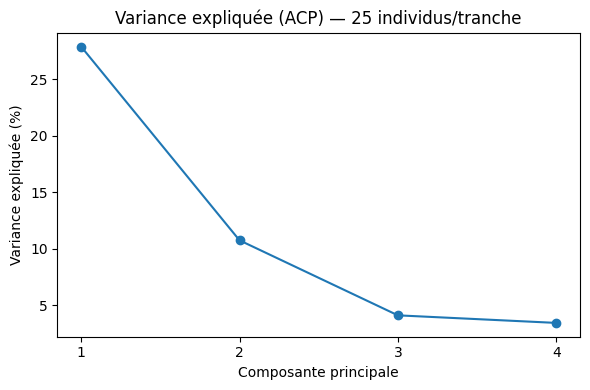

Figure : PCA_bins_scree.png


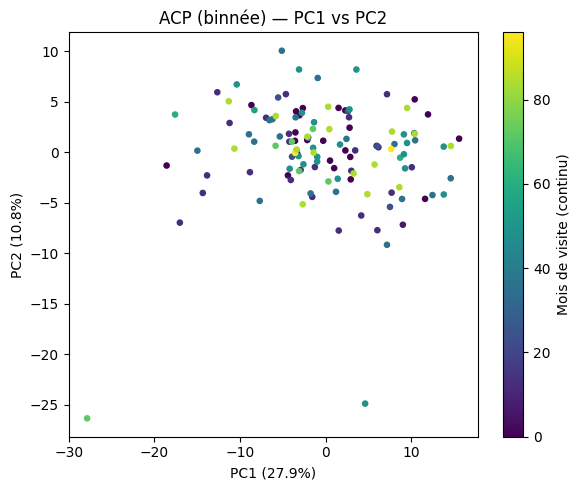

Figure : PCA_bins_PC1_PC2.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Fichier UMAP : UMAP_bins_scores.csv


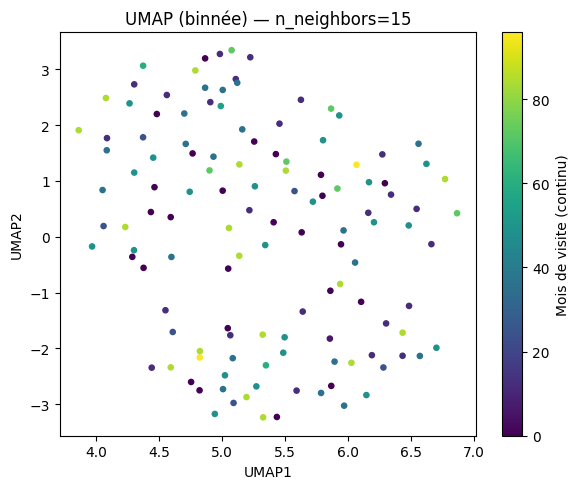

Figure : UMAP_bins.png


In [ ]:
# --- ACP & UMAP avec binning temporel et échantillonnage 25 individus/tranche ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 0) Données
df_all = DF_PROTEIN_IMP_SC.copy()

# Vérifs de base
if "visit_month" not in df_all.columns:
    raise ValueError("Colonne 'visit_month' absente de DF_PROTEIN_IMP_SC.")
vm = pd.to_numeric(df_all["visit_month"], errors="coerce")
df_all = df_all.assign(visit_month=vm).dropna(subset=["visit_month"])

# 1) Définition des tranches (nom, borne_inf, borne_sup) inclusives
month_bins = [
    ("0-3",      0,   3),
    ("6-18",     6,  18),
    ("24-36",   24,  36),
    ("48-60",   48,  60),
    ("72-108",  72, 108),
]

# 2) Échantillonnage : 25 individus (patients) par tranche
if "patient_id" not in df_all.columns:
    # Si patient_id indisponible, on prendra 25 lignes par tranche (fallback)
    print("[WARN] 'patient_id' manquant : échantillonnage par lignes (25/liste) au lieu d'individus.")

rng = np.random.RandomState(42)
samples = []
sel_report = []  # pour tracer le bilan de sélection

for label, lo, hi in month_bins:
    center = (lo + hi) / 2.0
    df_bin = df_all[(df_all["visit_month"] >= lo) & (df_all["visit_month"] <= hi)].copy()

    if df_bin.empty:
        sel_report.append((label, 0, 0))
        continue

    if "patient_id" in df_all.columns:
        # Choisir, pour chaque patient, l'observation la plus proche du centre de la tranche
        df_bin["_dist"] = (df_bin["visit_month"] - center).abs()
        df_rep = (
            df_bin.sort_values("_dist")
                  .groupby("patient_id", as_index=False)
                  .head(1)
                  .drop(columns=["_dist"])
        )
        n_unique = df_rep["patient_id"].nunique()

        if n_unique <= 25:
            chosen = df_rep
            taken = n_unique
        else:
            pat_ids = df_rep["patient_id"].unique()
            chosen_ids = rng.choice(pat_ids, size=25, replace=False)
            chosen = df_rep[df_rep["patient_id"].isin(chosen_ids)]
            taken = 25

        sel_report.append((label, n_unique, taken))
        chosen = chosen.assign(time_bin=label, bin_center=center)
        samples.append(chosen)
    else:
        # Fallback si pas de patient_id : 25 lignes max, les plus proches du centre
        df_bin["_dist"] = (df_bin["visit_month"] - center).abs()
        df_rep = df_bin.sort_values("_dist").head(min(25, len(df_bin))).drop(columns=["_dist"])
        sel_report.append((label, len(df_bin), len(df_rep)))
        df_rep = df_rep.assign(time_bin=label, bin_center=center)
        samples.append(df_rep)

# 3) Concaténation des échantillons
if len(samples) == 0:
    raise ValueError("Aucune donnée retenue dans les tranches spécifiées.")
df = pd.concat(samples, axis=0, ignore_index=True)

# Bilan de sélection
report_df = pd.DataFrame(sel_report, columns=["bin", "n_individus_disponibles", "n_pris"])
print("\n=== Bilan sélection par tranche ===")
print(report_df.to_string(index=False))
report_df.to_csv("BIN_selection_report.csv", index=False)

# 4) Définition des features (les colonnes protéines)
context_cols = {
    "patient_id", "visit_month", "time_bin", "bin_center",
    "updrs_1", "updrs_2", "updrs_3", "updrs_4",
    "upd23b_clinical_state_on_medication"
}
feature_cols = [c for c in df.columns if c not in context_cols]
X = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Sécurité : DF_IMP_SC est déjà standardisé; on remplace seulement d'éventuels NaN par 0
if X.isna().any().any():
    X = X.fillna(0.0)

n_samples, n_features = X.shape
if n_samples < 2 or n_features < 1:
    raise ValueError(f"Matrice features invalide: {n_samples} x {n_features}")

# 5) ACP à ncomp composantes

n_comp = 4

pca = PCA(n_components=n_comp, random_state=42)
scores = pca.fit_transform(X.values)
expl_var = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

# Scores + sauvegarde
scores_df = pd.DataFrame(scores, columns=[f"PC{i}" for i in range(1, n_comp+1)])
scores_df["visit_month"] = df["visit_month"].values
if "patient_id" in df.columns: scores_df["patient_id"] = df["patient_id"].values
scores_df["time_bin"] = df["time_bin"].values
scores_df.to_csv("PCA_bins_scores.csv", index=False)

# Loadings
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f"PC{i}" for i in range(1, n_comp+1)])
loadings.reset_index().rename(columns={"index": "feature"}).to_csv("PCA_bins_loadings.csv", index=False)

print("\nVariance expliquée (%) par composante :")
for i, v in enumerate(expl_var, 1):
    print(f"  PC{i}: {v*100:.2f}%")
print(f"Variance cumulée (PC1–PC{n_comp}): {cum_var[-1]*100:.2f}%")
print("Fichiers ACP : PCA_bins_scores.csv, PCA_bins_loadings.csv")

# Figures ACP
# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, n_comp+1), expl_var*100, marker='o')
plt.title("Variance expliquée (ACP) — 25 individus/tranche")
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (%)")
plt.xticks(list(range(1, n_comp+1)))
plt.tight_layout()
plt.savefig("PCA_bins_scree.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure : PCA_bins_scree.png")

# PC1 vs PC2 (couleur = visit_month, gradient continu)
if n_comp >= 2:
    plt.figure(figsize=(6,5))
    sc = plt.scatter(scores_df["PC1"], scores_df["PC2"],
                     c=pd.to_numeric(scores_df["visit_month"], errors="coerce"), s=14)
    cbar = plt.colorbar(sc); cbar.set_label("Mois de visite (continu)")
    plt.title("ACP (binnée) — PC1 vs PC2")
    plt.xlabel(f"PC1 ({expl_var[0]*100:.1f}%)"); plt.ylabel(f"PC2 ({expl_var[1]*100:.1f}%)")
    plt.tight_layout()
    plt.savefig("PCA_bins_PC1_PC2.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Figure : PCA_bins_PC1_PC2.png")

# 6) UMAP 2D (couleur = visit_month, gradient continu)
try:
    import umap  # pip install umap-learn
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Le module 'umap-learn' est requis. Installe-le avec: pip install umap-learn") from e

n_neighbors = min(15, max(2, n_samples - 1))
if n_neighbors < 2:
    print("[WARN] Trop peu d'échantillons pour UMAP (n < 3). Étape UMAP ignorée.")
else:
    umap_model = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=0.1,
        metric="euclidean",
        random_state=42
    )
    embedding = umap_model.fit_transform(X.values)
    umap_df = pd.DataFrame({"UMAP1": embedding[:,0], "UMAP2": embedding[:,1]})
    umap_df["visit_month"] = df["visit_month"].values
    if "patient_id" in df.columns: umap_df["patient_id"] = df["patient_id"].values
    umap_df["time_bin"] = df["time_bin"].values

    umap_df.to_csv("UMAP_bins_scores.csv", index=False)
    print("Fichier UMAP : UMAP_bins_scores.csv")

    plt.figure(figsize=(6,5))
    sc = plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"],
                     c=pd.to_numeric(umap_df["visit_month"], errors="coerce"), s=14)
    cbar = plt.colorbar(sc); cbar.set_label("Mois de visite (continu)")
    plt.title(f"UMAP (binnée) — n_neighbors={n_neighbors}")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.savefig("UMAP_bins.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Figure : UMAP_bins.png")



=== Bilan sélection par tranche ===
   bin  n_individus_disponibles  n_pris
   0-3                      195      25
  6-18                      206      25
 24-36                      216      25
 48-60                      158      25
72-108                       41      25

Variance expliquée (%) par composante :
  PC1: 27.87%
  PC2: 10.76%
  PC3: 4.13%
  PC4: 3.46%
  PC5: 2.88%
  PC6: 2.67%
Variance cumulée (PC1–PC6): 51.76%
Fichiers ACP : PCA_bins_scores.csv, PCA_bins_loadings.csv


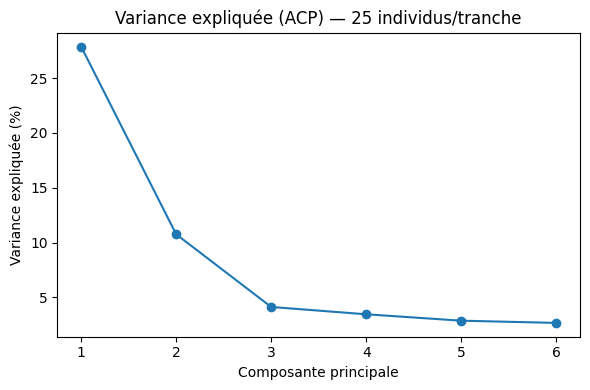

Figure : PCA_bins_scree.png


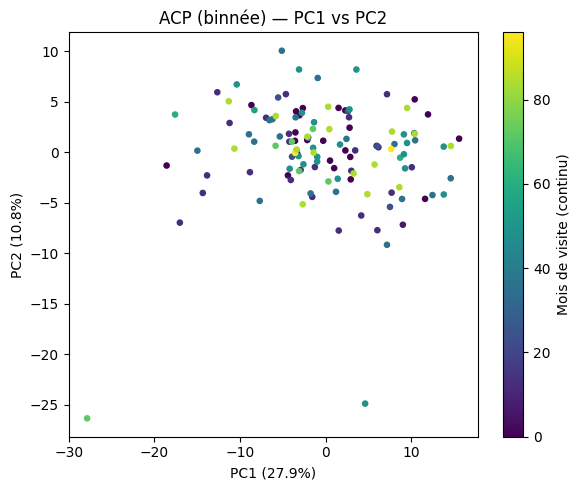

Figure : PCA_bins_PC1_PC2.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Fichier UMAP : UMAP_bins_scores_UPDRS.csv
UPDRS total — min: 0.00 | max: 92.00


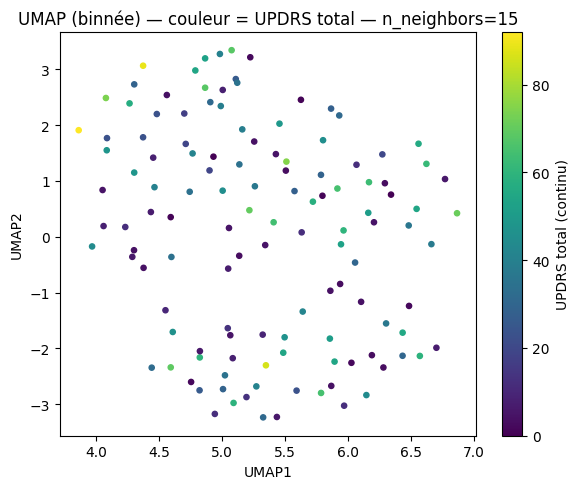

Figure : UMAP_bins_UPDRS.png


In [ ]:
# --- ACP & UMAP avec binning temporel et échantillonnage 25 individus/tranche ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 0) Données
df_all = DF_PROTEIN_IMP_SC.copy()

# Vérifs de base
if "visit_month" not in df_all.columns:
    raise ValueError("Colonne 'visit_month' absente de DF_PROTEIN_IMP_SC.")
vm = pd.to_numeric(df_all["visit_month"], errors="coerce")
df_all = df_all.assign(visit_month=vm).dropna(subset=["visit_month"])

# -- UPDRS total (somme des 4 sous-échelles) --
up_cols = []
for i in range(1, 5):
    c_us = f"updrs_{i}"
    c_ns = f"updrs{i}"
    if c_us in df_all.columns:
        up_cols.append(c_us)
    elif c_ns in df_all.columns:
        up_cols.append(c_ns)
    else:
        raise ValueError(f"Colonne UPDRS manquante pour i={i} (ni 'updrs_{i}' ni 'updrs{i}')")

df_all[up_cols] = df_all[up_cols].apply(pd.to_numeric, errors="coerce")
df_all["updrs_total"] = df_all[up_cols].fillna(0).sum(axis=1)


# 1) Définition des tranches (nom, borne_inf, borne_sup) inclusives
month_bins = [
    ("0-3",      0,   3),
    ("6-18",     6,  18),
    ("24-36",   24,  36),
    ("48-60",   48,  60),
    ("72-108",  72, 108),
]

# 2) Échantillonnage : 25 individus (patients) par tranche
if "patient_id" not in df_all.columns:
    # Si patient_id indisponible, on prendra 25 lignes par tranche (fallback)
    print("[WARN] 'patient_id' manquant : échantillonnage par lignes (25/liste) au lieu d'individus.")

rng = np.random.RandomState(42)
samples = []
sel_report = []  # pour tracer le bilan de sélection

for label, lo, hi in month_bins:
    center = (lo + hi) / 2.0
    df_bin = df_all[(df_all["visit_month"] >= lo) & (df_all["visit_month"] <= hi)].copy()

    if df_bin.empty:
        sel_report.append((label, 0, 0))
        continue

    if "patient_id" in df_all.columns:
        # Choisir, pour chaque patient, l'observation la plus proche du centre de la tranche
        df_bin["_dist"] = (df_bin["visit_month"] - center).abs()
        df_rep = (
            df_bin.sort_values("_dist")
                  .groupby("patient_id", as_index=False)
                  .head(1)
                  .drop(columns=["_dist"])
        )
        n_unique = df_rep["patient_id"].nunique()

        if n_unique <= 25:
            chosen = df_rep
            taken = n_unique
        else:
            pat_ids = df_rep["patient_id"].unique()
            chosen_ids = rng.choice(pat_ids, size=25, replace=False)
            chosen = df_rep[df_rep["patient_id"].isin(chosen_ids)]
            taken = 25

        sel_report.append((label, n_unique, taken))
        chosen = chosen.assign(time_bin=label, bin_center=center)
        samples.append(chosen)
    else:
        # Fallback si pas de patient_id : 25 lignes max, les plus proches du centre
        df_bin["_dist"] = (df_bin["visit_month"] - center).abs()
        df_rep = df_bin.sort_values("_dist").head(min(25, len(df_bin))).drop(columns=["_dist"])
        sel_report.append((label, len(df_bin), len(df_rep)))
        df_rep = df_rep.assign(time_bin=label, bin_center=center)
        samples.append(df_rep)

# 3) Concaténation des échantillons
if len(samples) == 0:
    raise ValueError("Aucune donnée retenue dans les tranches spécifiées.")
df = pd.concat(samples, axis=0, ignore_index=True)

# Bilan de sélection
report_df = pd.DataFrame(sel_report, columns=["bin", "n_individus_disponibles", "n_pris"])
print("\n=== Bilan sélection par tranche ===")
print(report_df.to_string(index=False))
report_df.to_csv("BIN_selection_report.csv", index=False)

# 4) Définition des features (les colonnes protéines)
context_cols = {
    "patient_id", "visit_month", "time_bin", "bin_center",
    "updrs_1", "updrs_2", "updrs_3", "updrs_4",
    "upd23b_clinical_state_on_medication",
    "updrs_total"
}
feature_cols = [c for c in df.columns if c not in context_cols]
X = df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Sécurité : DF_IMP_SC est déjà standardisé; on remplace seulement d'éventuels NaN par 0
if X.isna().any().any():
    X = X.fillna(0.0)

n_samples, n_features = X.shape
if n_samples < 2 or n_features < 1:
    raise ValueError(f"Matrice features invalide: {n_samples} x {n_features}")

# 5) ACP à n_comp composantes

n_comp = 6

pca = PCA(n_components=n_comp, random_state=42)
scores = pca.fit_transform(X.values)
expl_var = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

# Scores + sauvegarde
scores_df = pd.DataFrame(scores, columns=[f"PC{i}" for i in range(1, n_comp+1)])
scores_df["visit_month"] = df["visit_month"].values
if "patient_id" in df.columns: scores_df["patient_id"] = df["patient_id"].values
scores_df["time_bin"] = df["time_bin"].values
scores_df.to_csv("PCA_bins_scores.csv", index=False)

# Loadings
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f"PC{i}" for i in range(1, n_comp+1)])
loadings.reset_index().rename(columns={"index": "feature"}).to_csv("PCA_bins_loadings.csv", index=False)

print("\nVariance expliquée (%) par composante :")
for i, v in enumerate(expl_var, 1):
    print(f"  PC{i}: {v*100:.2f}%")
print(f"Variance cumulée (PC1–PC{n_comp}): {cum_var[-1]*100:.2f}%")
print("Fichiers ACP : PCA_bins_scores.csv, PCA_bins_loadings.csv")

# Figures ACP
# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, n_comp+1), expl_var*100, marker='o')
plt.title("Variance expliquée (ACP) — 25 individus/tranche")
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (%)")
plt.xticks(list(range(1, n_comp+1)))
plt.tight_layout()
plt.savefig("PCA_bins_scree.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure : PCA_bins_scree.png")

# PC1 vs PC2 (couleur = visit_month, gradient continu)
if n_comp >= 2:
    plt.figure(figsize=(6,5))
    sc = plt.scatter(scores_df["PC1"], scores_df["PC2"],
                     c=pd.to_numeric(scores_df["visit_month"], errors="coerce"), s=14)
    cbar = plt.colorbar(sc); cbar.set_label("Mois de visite (continu)")
    plt.title("ACP (binnée) — PC1 vs PC2")
    plt.xlabel(f"PC1 ({expl_var[0]*100:.1f}%)"); plt.ylabel(f"PC2 ({expl_var[1]*100:.1f}%)")
    plt.tight_layout()
    plt.savefig("PCA_bins_PC1_PC2.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Figure : PCA_bins_PC1_PC2.png")

# 6) UMAP 2D (couleur = UPDRS total, gradient continu)
try:
    import umap  # pip install umap-learn
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Le module 'umap-learn' est requis. Installe-le avec: pip install umap-learn") from e

n_neighbors = min(15, max(2, n_samples - 1))
if n_neighbors < 2:
    print("[WARN] Trop peu d'échantillons pour UMAP (n < 3). Étape UMAP ignorée.")
else:
    umap_model = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=0.1,
        metric="euclidean",
        random_state=42
    )
    embedding = umap_model.fit_transform(X.values)

    umap_df = pd.DataFrame({"UMAP1": embedding[:, 0], "UMAP2": embedding[:, 1]}, index=df.index)
    umap_df["updrs_total"] = pd.to_numeric(df["updrs_total"], errors="coerce").values
    umap_df["visit_month"] = df["visit_month"].values
    if "patient_id" in df.columns:
        umap_df["patient_id"] = df["patient_id"].values
    umap_df["time_bin"] = df["time_bin"].values

    umap_df.to_csv("UMAP_bins_scores_UPDRS.csv", index=False)
    print("Fichier UMAP : UMAP_bins_scores_UPDRS.csv")
    print(f"UPDRS total — min: {np.nanmin(umap_df['updrs_total']):.2f} | max: {np.nanmax(umap_df['updrs_total']):.2f}")

    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        umap_df["UMAP1"], umap_df["UMAP2"],
        c=umap_df["updrs_total"], s=14
    )
    cbar = plt.colorbar(sc)
    cbar.set_label("UPDRS total (continu)")
    plt.title(f"UMAP (binnée) — couleur = UPDRS total — n_neighbors={n_neighbors}")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.savefig("UMAP_bins_UPDRS.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Figure : UMAP_bins_UPDRS.png")
